In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import csv
import pathlib
import os
import networkx as nx 
import matplotlib as mpl
import mpl_toolkits 
from mpl_toolkits.basemap import Basemap as Basemap
%matplotlib inline

# Function Defenition

## Data Wrangling Functions

## Read Power Data Func Def

In [2]:
#Get all scenarios in a directory

def get_scenario_names(sen_name):
    lst = os.listdir(os.getcwd())
    lst = list(filter(lambda k: sen_name in k, lst))
    lst = list(filter(lambda k: '.jl' not in k, lst))
    lst = list(filter(lambda k: 'DACNon' not in k, lst))
    
    return lst

def create_fig_dir(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)
        print("Directory created successfully")
    else:
        print("Directory already exists")

def read_cost_data(dir_list, scenario_name_dict, directory_name="./"):
    
    costs_df = pd.DataFrame(columns=["scenario_name", "co2_percent", "h2_percent", "sf_percent", "total_cost", "Power", "H2", "CO2", "SynFuels", "ConvFuels"])

    for dir_name in dir_list:
        
        curr_results_directory =  directory_name + dir_name + "/Results/"
        
        
        cost_df = pd.read_csv(curr_results_directory + "costs_system.csv")
        total_cost = cost_df[cost_df['Costs'] == "cTotal"]['Total'].values[0] * 1e-9
        
        total_cost = cost_df[cost_df['Costs'] == "cTotal"]['Total'].values[0] * 1e-9
        power_cost = cost_df[cost_df['Costs'] == "cPower_Total"]['Total'].values[0] * 1e-9
        h2_cost = cost_df[cost_df['Costs'] == "cHSC_Total"]['Total'].values[0] * 1e-9
        csc_cost = cost_df[cost_df['Costs'] == "cCSC_Total"]['Total'].values[0] * 1e-9
        sf_cost = cost_df[cost_df['Costs'] == "cSF_Prod"]['Total'].values[0] * 1e-9
        conv_fuel_cost = cost_df[cost_df['Costs'] == "cConv_Fuels"]['Total'].values[0] * 1e-9
        

        if "No_SF" not in dir_name:
            co2_percent = (dir_name[39:42])
            h2_percent = (dir_name[31:34])
            sf_percent = float((dir_name[-3:]))
        else:
            co2_percent = (dir_name[42:45])
            h2_percent = (dir_name[34:37])
            sf_percent = 0
        
        curr_costs_df = pd.DataFrame(index = [scenario_name_dict[dir_name]],
                                     columns=["scenario_name", "co2_percent", "h2_percent", "sf_percent", "total_cost", "Power", "H2", "CO2", "SynFuels", "ConvFuels"],
                                     data=[[scenario_name_dict[dir_name], co2_percent, h2_percent, sf_percent, total_cost, power_cost, h2_cost, csc_cost, sf_cost, conv_fuel_cost]])

        costs_df = costs_df.append(curr_costs_df)
    

    return costs_df


In [3]:
def read_power_data(dir_list, scenario_name_dict, directory_name ="./"):
    
    power_cap_list = []
    power_gen_list = []
    power_battery_cap_list = []
    comb_power_capacity_list = []
    power_gen_zone_list = []
    power_zone_list = []
    power_capacity_zone_list = []

    for dir_name in dir_list:
        
        if "No_SF" not in dir_name:
            co2_percent = (dir_name[39:42])
            h2_percent = (dir_name[31:34])
            sf_percent = float((dir_name[-3:]))
        else:
            co2_percent = (dir_name[42:45])
            h2_percent = (dir_name[34:37])
            sf_percent = 0
        curr_dir_name = directory_name + dir_name + "/Results/"

        resource_dict = {'CCGT' : 'Gas', 'OCGT' : 'Gas', 'CCGT_CCS' : 'Gas w/ CCS',
             'biomass' : 'Biomass',
             'coal' :'Coal',
             'lignite' : 'Coal',
             'oil' : 'Oil',
             'offwind-dc' : 'Wind - Offshore' , 'offwind-ac' : 'Wind - Offshore', 'onwind' : 'Wind - Onshore',
            'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
             'solar' : 'Solar',
            'nuclear' : 'Nuclear'}

        #Raw Data
        power_df = pd.read_csv(curr_dir_name + "/power.csv").drop([0,1])
        weights_df = pd.read_csv(curr_dir_name + "/time_weights.csv")
        capacity_df = pd.read_csv(curr_dir_name + "/capacity.csv")

        #########Power###########

        #Wrangle Power Data into long format
        power_long_df = power_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                                 resource_type = power_long_df["variable"].str[6:],
                                interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})
        
        zones = power_long_df["zone"].unique()

        #Add weights to long power data frame
        power_long_df = power_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        #Aggregate power data by zone
        power_zone_df = power_long_df.groupby(['zone','resource_type']).agg({'value': 'sum'}).query("zone != 'Total'").reset_index()
        power_zone_df = power_zone_df.assign(generation_twh = power_zone_df["value"] * 0.000001)
        power_zone_df['scenario'] = scenario_name_dict[dir_name]
        power_zone_df['zone'] = power_zone_df['zone'].str[0:3]
        power_zone_list.append(power_zone_df)

        power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','interval']).agg({'value': 'sum'}).reset_index()

        #Aggregate power by generator type
        power_gen_total_df = power_long_df.query("variable != 'Total'").assign(gen = power_long_df["value"] * power_long_df["Weight"]).groupby(['resource_type']).agg({'gen': 'sum'}).reset_index()
        power_gen_total_df = power_gen_total_df.assign(generation_twh = power_gen_total_df["gen"] * 0.000001, scenario = scenario_name_dict[dir_name],
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        power_gen_list.append(power_gen_total_df)


        ######Generator Capacity##########

        #Aggregate capacity total capacity
        end_capacity_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name])

        end_capacity_scenario_df = end_capacity_scenario_df.assign(capacity_gw = end_capacity_scenario_df["EndCap"] * 0.001).reset_index().assign(scenario = scenario_name_dict[dir_name] ,
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        
        end_capacity_zone_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type','zone']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name] ,
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        
        power_cap_list.append(end_capacity_scenario_df)
        power_capacity_zone_list.append(end_capacity_zone_scenario_df)
        ######Battery Capacity###########

        end_battery_capacity_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type']).agg({'EndEnergyCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name])

        end_battery_capacity_scenario_df = end_battery_capacity_scenario_df.assign(capacity_mw = end_battery_capacity_scenario_df["EndEnergyCap"]).reset_index()

        power_battery_cap_list.append(end_battery_capacity_scenario_df)
        
        ######Comp Power and Capacity DF#####
        
        comb_power_capacity_df = pd.merge(power_gen_total_df, end_capacity_scenario_df, on = ['resource_type', 'scenario'])
        comb_power_capacity_df["cf"] = comb_power_capacity_df.gen / comb_power_capacity_df.EndCap / 8760
        
        comb_power_capacity_list.append(comb_power_capacity_df)
        
    return power_gen_list, power_cap_list, power_battery_cap_list, comb_power_capacity_list, power_zone_list, power_capacity_zone_list
    
    


In [4]:
def read_fossil_fuel_data(dir_list, scenario_name_dict, directory_name ="./"):
    
    all_fuel_cons_list = []

    for dir_name in dir_list:
        
        if "No_SF" not in dir_name:
            co2_percent = (dir_name[39:42])
            h2_percent = (dir_name[31:34])
            sf_percent = float((dir_name[-3:]))
        else:
            co2_percent = (dir_name[42:45])
            h2_percent = (dir_name[34:37])
            sf_percent = 0
        
        curr_dir_name = directory_name + dir_name + "/Results/"
        
        ###H2 Fuel Consumption
        h2_df = pd.read_csv(curr_dir_name + "/Results_HSC/HSC_h2_generation_discharge.csv").iloc[1].to_frame().iloc[1:-1]
        h2_df.columns = ["Generation"]
        h2_df.index.name = None  # Removing the index name
        # Renaming the index
        h2_df = h2_df.rename_axis('H2_Resource')
        
        hsc_generator_data_df = pd.read_csv(curr_dir_name + "../HSC_generation.csv")[['H2_Resource', 'etaFuel_MMBtu_p_tonne', 'Fuel']].set_index('H2_Resource')
        
        h2_df = h2_df.join(hsc_generator_data_df)
        h2_df['fuel_cons'] = h2_df['Generation'] * h2_df['etaFuel_MMBtu_p_tonne']
        hsc_fuel_cons_df = h2_df.groupby('Fuel')[['fuel_cons']].sum()
        
        hsc_fuel_cons_df = hsc_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                  sector = "H2").reset_index()
        
        ###Power Fuel Consumption
        power_df = pd.read_csv(curr_dir_name + "/power.csv").iloc[1].to_frame().iloc[1:-1]
        power_df.columns = ["Generation"]
        power_df.index.name = None  # Removing the index name

        # Renaming the index
        power_df = power_df.rename_axis('Resource')
        
        generator_data_df = pd.read_csv(curr_dir_name + "../Generators_data.csv")[['Resource', 'Heat_Rate_MMBTU_per_MWh', 'Fuel']].set_index('Resource')
        
        power_df = power_df.join(generator_data_df)
        power_df['fuel_cons'] = power_df['Generation'] * power_df['Heat_Rate_MMBTU_per_MWh']
        power_fuel_cons_df = power_df.groupby('Fuel')[['fuel_cons']].sum()
        
        power_fuel_cons_df = power_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                   sector = "Power").reset_index()
        
        ###DAC Fuel Consumption
        csc_df = pd.read_csv(curr_dir_name + "/Results_CSC/CSC_DAC_capacity.csv").rename(columns = {"Resource" : "CO2_Resource"})
        csc_df = (csc_df[csc_df["CO2_Resource"] != "Total"]).set_index('CO2_Resource')
        dac_data_df = pd.read_csv(curr_dir_name + "../CSC_capture.csv")[['CO2_Resource', 'etaFuel_MMBtu_per_tonne', 'Fuel']].set_index('CO2_Resource')
        csc_df = dac_data_df.join(csc_df)
        
        
        csc_df['fuel_cons'] = csc_df['Annual_Capture'] * csc_df['etaFuel_MMBtu_per_tonne']
        csc_fuel_cons_df = csc_df.groupby('Fuel')[['fuel_cons']].sum()
        
        csc_fuel_cons_df = csc_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                   sector = "CSC").reset_index()
        
        
        
        ### Liquid Fuel Consumption
        
        diesel_demand = pd.read_csv(curr_dir_name + "../Liquid_Fuels_Diesel_Demand.csv").iloc[:,4:].astype(float).sum().sum()
        gasoline_demand = pd.read_csv(curr_dir_name + "../Liquid_Fuels_Gasoline_Demand.csv").iloc[:,4:].astype(float).sum().sum()
        
        diesel_demand_df = pd.DataFrame({'Fuel': ['Diesel'],
                                         'fuel_cons':[diesel_demand], 
                                         'scenario': [scenario_name_dict[dir_name]],
                   'co2_percent': [co2_percent],
                   'h2_percent': [h2_percent],
                    'sf_percent':[sf_percent],
                   'sector': ['Trans']})
        
        gasoline_demand_df = pd.DataFrame({'Fuel': ['Gasoline'],
                                         'fuel_cons':[gasoline_demand], 
                                         'scenario': [scenario_name_dict[dir_name]],
                   'co2_percent': [co2_percent],
                   'h2_percent': [h2_percent],
                    'sf_percent':[sf_percent],
                   'sector': ['Trans']})

        all_fuel_cons = pd.concat([power_fuel_cons_df, hsc_fuel_cons_df, csc_fuel_cons_df, diesel_demand_df, gasoline_demand_df]).query("Fuel != 'None' and Fuel != 'uranium' and Fuel != 'biomass'")
        all_fuel_cons["Fuel"] = all_fuel_cons["sector"]  + "_" + all_fuel_cons["Fuel"]
        
        
        all_fuel_cons_list.append(all_fuel_cons.reset_index())
        
        
    return pd.concat(all_fuel_cons_list)


In [5]:
def read_power_data_gas_granular(dir_list):
    
    power_cap_list = []
    power_gen_list = []
    power_battery_cap_list = []
    comb_power_capacity_list = []

    for dir_name in dir_list:

        resource_dict = {'CCGT' : 'Gas_CCGT', 'OCGT' : 'Gas_OCGT', 'CCGT_CCS' : 'Gas w/ CCS',
             'biomass' : 'Biomass',
             'coal' :'Coal',
             'lignite' : 'Coal',
             'oil' : 'Oil',
             'offwind-dc' : 'Wind' , 'offwind-ac' : 'Wind', 'onwind' : 'Wind',
            'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
             'solar' : 'Solar',
            'nuclear' : 'Nuclear'}

        #Raw Data
        power_df = pd.read_csv("./" + dir_name + "/Results/power.csv").drop([0,1])
        weights_df = pd.read_csv("./" + dir_name + "/Results/time_weights.csv")
        capacity_df = pd.read_csv("./" + dir_name + "/Results/capacity.csv")

        #########Power###########

        #Wrangle Power Data into long format
        power_long_df = power_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                                 resource_type = power_long_df["variable"].str[6:],
                                interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})

        zones = power_long_df["zone"].unique()

        power_total_df = power_long_df.query("zone == 'Total'")
        #Add weights to long power data frame
        power_long_df = power_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        #Aggregate power data by zone
        power_zone_df = power_long_df.groupby(['zone','interval']).agg({'value': 'sum'}).query("zone != 'Total'").reset_index()

        power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','interval']).agg({'value': 'sum'}).reset_index()

        #Aggregate power by generator type
        power_gen_total_df = power_long_df.query("variable != 'Total'").assign(gen = power_long_df["value"] * power_long_df["Weight"]).groupby(['resource_type']).agg({'gen': 'sum'}).reset_index()
        power_gen_total_df = power_gen_total_df.assign(generation_twh = power_gen_total_df["gen"] * 0.000001, scenario = scenario_name_dict[dir_name])

        power_gen_list.append(power_gen_total_df)


    return power_gen_list
    
    

In [6]:
def read_h2_data(h2_dir_list,scenario_name_dict, directory_name):

    h2_cap_list = []
    h2_gen_list = []
    h2_stor_cap_list = []
    
    for h2_dir_name in h2_dir_list:
        
        if "No_SF" not in h2_dir_name:
            co2_percent = (h2_dir_name[39:42])
            h2_percent = (h2_dir_name[31:34])
            sf_percent = float((h2_dir_name[-3:]))
        else:
            co2_percent = (h2_dir_name[42:45])
            h2_percent = (h2_dir_name[34:37])
            sf_percent = 0
        
        curr_dir_name = directory_name + h2_dir_name + "/Results/Results_HSC/"
        curr_dir_name_short = directory_name + h2_dir_name + "/Results/"

        h2_discharge_df = pd.read_csv(curr_dir_name + "HSC_h2_generation_discharge.csv").drop([0,1])
        weights_df = pd.read_csv(curr_dir_name_short +  "time_weights.csv")
        h2_capacity_df = pd.read_csv(curr_dir_name + "HSC_generation_storage_capacity.csv")

        h2_discharge_long_df = h2_discharge_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        h2_discharge_long_df =  h2_discharge_long_df.assign(
                                interval = pd.to_numeric(h2_discharge_long_df["Resource"].str[1:]) )

        h2_discharge_long_df = h2_discharge_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        mask = h2_discharge_long_df["variable"].str.contains("Above_ground_storage")
        h2_discharge_long_df = h2_discharge_long_df[~mask]

        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Electrolyzer"),"resource_type"] = "Electrolyzer"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Large_ATR_wCCS"),"resource_type"] = "ATR w/ CCS"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("SMR_w_CCS"),"resource_type"] = "SMR w/ CCS"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("SMR(?![\w\s]*CCS)"), "resource_type"] = "SMR"



        h2_discharge_total_df = h2_discharge_long_df.query("variable != 'Total'").assign(h2_prod = h2_discharge_long_df["value"] * h2_discharge_long_df["Weight"]*0.001).groupby(['resource_type']).agg({'h2_prod': 'sum'}).reset_index()
        h2_discharge_total_df = h2_discharge_total_df.assign(scenario = scenario_name_dict[h2_dir_name],
                                                             co2_percent = co2_percent, h2_percent = h2_percent, sf_percent = sf_percent)

        h2_gen_list.append(h2_discharge_total_df)

        mask = h2_capacity_df["Resource"].str.contains("Above_ground_storage")
        h2_storage_capacity_df = h2_capacity_df[mask]
        h2_capacity_df = h2_capacity_df[~mask]


        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Electrolyzer"),"resource_type"] = "Electrolyzer"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Large_ATR_wCCS"),"resource_type"] = "ATR w/ CCS"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("SMR_w_CCS"),"resource_type"] = "SMR w/ CCS"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("SMR(?![\w\s]*CCS)"), "resource_type"] = "SMR"

        h2_storage_capacity_df["Resource"] = "Above Ground Storage"

        
        end_capacity_scenario_df = h2_capacity_df.query("Resource != 'Total'").groupby(['resource_type']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[h2_dir_name],
                                                             co2_percent = co2_percent, h2_percent = h2_percent, sf_percent = sf_percent).reset_index()

        h2_cap_list.append(end_capacity_scenario_df)
        
        end_storage_scenario_df = h2_storage_capacity_df.groupby(['Resource']).agg({'EndEnergyCap': 'sum'}).assign(scenario = scenario_name_dict[h2_dir_name]).reset_index()

        h2_stor_cap_list.append(end_storage_scenario_df)
        
    return h2_gen_list, h2_cap_list,h2_stor_cap_list


In [7]:
def read_emission_data(dir_list, scenario_dict, directory):

    emissions_df = pd.DataFrame(columns=["scenario_name", "h2_percent", "co2_percent", "sf_percent", "Power Plant Emissions", "Power Plant PSC Abatement",\
                                         "H2 Plant Emissions", "H2 Plant PSC Abatement", "DAC Plant Emissions", "DAC Abatement","DAC Fuel CCS", "CO2 Storage",\
                                         "SF CO2 In", "SF Plant Capture", "SynFuel Emissions", "Conventional Fuel Emissions"])

    for dir_name in dir_list:

        curr_dir_name = directory + dir_name + "/Results/"
        
        curr_power_em = pd.read_csv(curr_dir_name+"emissions.csv")
        
        #Power plant emissions
        curr_power_em = pd.read_csv(curr_dir_name+"emissions.csv").iloc[1,11] * 1e-6
    
        #Hydrogen Emissions
        curr_hsc_em = pd.read_csv(curr_dir_name+"Results_HSC/HSC_emissions.csv").iloc[0,11]* 1e-6
             
        # read the Excel file
        sf_emissions_df = pd.read_csv(curr_dir_name+'Results_SynFuels/Syn_Fuel_Emissions_Balance.csv', header=None).iloc[:3].drop(1)        
        # Set the column names as the values in the third row
        sf_emissions_df.columns = sf_emissions_df.iloc[0]
        
        sf_co2_in = sf_emissions_df.iloc[1]['CO2_In'].astype(float).sum()*1e-6
        sf_emissions = sf_emissions_df.iloc[1]['SF_Prod_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Jetfuel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Diesel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Gasoline_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['ByProd_Cons_Emissions_1'].astype(float).sum()*1e-6
        conv_fuel_emissions = sf_emissions_df.iloc[1]['Conv_Diesel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                            sf_emissions_df.iloc[1]['Conv_Gasoline_Cons_Emissions'].astype(float).sum()*1e-6 + \
                            sf_emissions_df.iloc[1]['Conv_Jetfuel_Cons_Emissions'].astype(float).sum()*1e-6
        
        
        capture_zone_balance_df = pd.read_csv(curr_dir_name + 'Results_CSC/Zone_CO2_storage_balance.csv', header =None).iloc[:3].drop(1)
        capture_zone_balance_df.columns = capture_zone_balance_df.iloc[0] 
       
        emission_zone_balance_df = pd.read_csv(curr_dir_name + 'Results_CSC/Zone_CO2_emission_balance.csv', header =None).iloc[:3].drop(1)
        emission_zone_balance_df.columns = emission_zone_balance_df.iloc[0]
        
        curr_power_cc = -1 * capture_zone_balance_df.iloc[1]['Power CCS'].astype(float).sum()*1e-6
        curr_h2_cc = -1 * capture_zone_balance_df.iloc[1]['H2 CCS'].astype(float).sum()*1e-6
        curr_sf_cc = -1 * capture_zone_balance_df.iloc[1]['Synfuel Production Capture'].astype(float).sum()*1e-6
        curr_co2_stor = -1 * capture_zone_balance_df.iloc[1]['CO2 Storage'].astype(float).sum()*1e-6
        curr_dac_cc = -1 * capture_zone_balance_df.iloc[1]['DAC Capture'].astype(float).sum() *1e-6#+ 
                            #capture_zone_balance_df.iloc[1]['DAC Fuel CCS'].astype(float).sum())*1e-6
        curr_dac_fuel_ccs = -1 * capture_zone_balance_df.iloc[1]['DAC Fuel CCS'].astype(float).sum()*1e-6
               
        curr_dac_em = emission_zone_balance_df.iloc[1]['DAC Emissions'].astype(float).sum()*1e-6 +\
                        emission_zone_balance_df.iloc[1]['CO2 Pipeline Loss'].astype(float).sum()*1e-6
                        
        curr_power_em = curr_power_em + curr_power_cc * -1
        curr_hsc_em = curr_hsc_em + curr_h2_cc * -1
        
        if "No_SF" not in dir_name:
            co2_percent = (dir_name[39:42])
            h2_percent = (dir_name[31:34])
            sf_percent = float((dir_name[-3:]))
        else:
            co2_percent = (dir_name[42:45])
            h2_percent = (dir_name[34:37])
            sf_percent = 0
        
        curr_emissions_df = pd.DataFrame(index = [scenario_dict[dir_name]],\
                                         columns=["scenario_name", "h2_percent", "co2_percent", "sf_percent", "Power Plant Emissions", 
                                                  "Power Plant PSC Abatement", "H2 Plant Emissions", \
                                                  "H2 Plant PSC Abatement", "DAC Plant Emissions", "DAC Abatement", "DAC Fuel CCS", "CO2 Storage",\
                                                  "SF CO2 In","SF Plant Capture", "SynFuel Emissions", "Conventional Fuel Emissions"], \
                                         data=[[scenario_dict[dir_name], h2_percent, co2_percent, sf_percent, curr_power_em, curr_power_cc, curr_hsc_em, \
                                                curr_h2_cc, curr_dac_em, curr_dac_cc, curr_dac_fuel_ccs, curr_co2_stor,\
                                                sf_co2_in, curr_sf_cc, sf_emissions, conv_fuel_emissions]])
        
        emissions_df = emissions_df.append(curr_emissions_df)
        
    emissions_summary_df = pd.DataFrame()
    emissions_summary_df["Net Power Plant Emissions"] = emissions_df["Power Plant Emissions"] 
    emissions_summary_df["Net H2 Plant Emissions"] = emissions_df["H2 Plant Emissions"] 
    emissions_summary_df["Net DAC Plant Emissions"] = emissions_df["DAC Plant Emissions"] + emissions_df["DAC Abatement"]
    #emissions_summary_df["SF Emissions"] = emissions_df["SF Emissions"]
    
    
    return emissions_df, emissions_summary_df


In [8]:


def fig_emissions_co2_stor_util(df, dir_name):
    columns_to_plot = ["SF CO2 In","CO2 Storage"]

    # create a new dataframe with only the selected columns
    df_stacked = df[columns_to_plot]

    # plot the stacked bar chart
    ax = df_stacked.plot(kind="bar", stacked=True, figsize=(10, 6), legend=True)

    # add the scenario names as x-axis labels
    ax.set_xticklabels(df["scenario_name"])

    # add a title and axis labels
    plt.title("Captured CO2 by Scenario")
    plt.xlabel("Scenario")
    plt.ylabel("Emissions (MTonnes)")

    plt.savefig(dir_name + 'Figures/emissions_util_stor.png', dpi=300, bbox_inches='tight')
    # show the plot
    plt.show()

def fig_emissions(df, dir_name):
    columns_to_plot = ["Power Plant Emissions","Power Plant PSC Abatement", "H2 Plant Emissions","H2 Plant PSC Abatement", "DAC Plant Emissions",
                       "DAC Abatement", "SynDiesel Emissions", "SynByProd Emissions", "Conventional Fuel Emissions"]

    # create a new dataframe with only the selected columns
    df_stacked = df[columns_to_plot]

    # plot the stacked bar chart
    ax = df_stacked.plot(kind="bar", stacked=True, figsize=(10, 6), legend=True)

    # add the scenario names as x-axis labels
    ax.set_xticklabels(df["scenario_name"])

    # add a title and axis labels
    plt.title("Emissions Breakdown by Scenario")
    plt.xlabel("Scenario")
    plt.ylabel("Emissions (MTonnes)")

    plt.savefig(dir_name + 'Figures/emissions.png', dpi=300, bbox_inches='tight')
    # show the plot
    plt.show()

def fig_emissions_rel(df, dir_name):
    columns_to_plot = ["Power Plant Emissions","Power Plant PSC Abatement", "H2 Plant Emissions","H2 Plant PSC Abatement", "DAC Plant Emissions",
                       "DAC Abatement", "SynDiesel Emissions", "SynByProd Emissions", "Conventional Fuel Emissions"]

    # select the base scenario
    base_scenario = df.iloc[0][columns_to_plot]
    print(base_scenario)

    # create a new dataframe with only the selected columns, and compute the differences with the base scenario
    df_diff = df[columns_to_plot].apply(lambda x: x - base_scenario, axis=1)

    # plot the stacked bar chart
    ax = df_diff.plot(kind="bar", stacked=True, figsize=(10, 6), legend=True)

    # add the scenario names as x-axis labels
    ax.set_xticklabels(df["scenario_name"])

    # add a title and axis labels
    plt.title("Emissions Breakdown by Scenario (Relative to Base Scenario)")
    plt.xlabel("Scenario")
    plt.ylabel("Emissions (MTonnes)")

    plt.savefig(dir_name + 'Figures/emissions_rel.png', dpi=300, bbox_inches='tight')
    # show the plot
    plt.show()


import plotly.graph_objects as go
import kaleido


source = [0, 0, 1, 1, 0]
target = [2, 3, 4, 5, 4]
value = [8, 2, 2, 8, 4]

link = dict(source = source, target = target, value = value)
data = go.Sankey(link = link)

fig = go.Figure(data)

#fig.show()
#fig.write_image(directory_name + "Figures/fig1.png")


In [9]:
def read_sen_emissions_costs(dir_list):
    
    sen_results_df = pd.DataFrame(columns=["scenario_name", "sen_factor", "curr_cost", "captured_co2"])

    for sen_file in dir_list:

        curr_cost = pd.read_csv("./" + sen_file + "/Results/status.csv").iloc[0]["Objval"]#.drop([0])
        curr_csc_em = sum(pd.read_csv("./" + sen_file + "/Results/Results_CSC/CSC_DAC_co2_capture_zone.csv").iloc[1,1:])*0.000001
        curr_sen_factor = float(sen_file[-3:])

        curr_sen_results_df = pd.DataFrame(columns=["scenario_name","sen_factor", "curr_cost", "captured_co2"],
                                           data=[[sen_file, curr_sen_factor, curr_cost, curr_csc_em]])

        sen_results_df = sen_results_df.append(curr_sen_results_df)


    return(sen_results_df.sort_values(by = "sen_factor"))

In [10]:
def read_h2_balance(h2_dir_list):
    
    h2_balance = []
    
    zone_dict = {"1" : "Belguim",
                "2" : "Germany",
                "3" : "Denmark_1",
                "4" : "Denmark_2",
                "5" : "France",
                "6" : "UK_1",
                "7" : "UK_2",
                "8" : "Netherlands",
                "9" : "Norway",
                "10" : "Sweden",}
    
    for h2_dir_name in h2_dir_list:
        curr_h2_balance_df = pd.read_csv("./" + h2_dir_name + "/Results/Results_HSC/HSC_h2_balance.csv", index_col = 0, header = None).head(3)#.melt()
        curr_h2_balance_df = pd.DataFrame(data = {'scenario_name' : scenario_name_dict[h2_dir_name], 
                                                  'var' : curr_h2_balance_df.iloc[0],
                                                  'zone' :curr_h2_balance_df.iloc[1], 'value' :curr_h2_balance_df.iloc[2]}).reset_index()
        
        #curr_h2_balance_df.loc[curr_h2_balance_df["index"].str.contains("Genertation"),"resource_type"] = "Electrolyzer"
        #h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Large_SMR"),"resource_type"] = "SMR"
        
        mask = curr_h2_balance_df["var"].str.contains("Generation")
        mask2 = curr_h2_balance_df["var"].str.fullmatch("Demand")
        
        curr_h2_balance_df = curr_h2_balance_df[mask | mask2]
        
        curr_h2_balance_df = curr_h2_balance_df.pivot(index = ['scenario_name', 'zone'], columns = ['var'], values = ['value']).reset_index()
        
        curr_h2_balance_df.columns = ["scenario", "zone", "demand", "generation"]
        
        curr_h2_balance_df[["demand", "generation"]] = curr_h2_balance_df[["demand", "generation"]].apply(pd.to_numeric)
        
        
        curr_h2_balance_df["demand"] = pd.Series(curr_h2_balance_df["demand"]) * -1
        
        curr_h2_balance_df = curr_h2_balance_df.replace({"zone": zone_dict})
        
        h2_balance.append(curr_h2_balance_df)

    return h2_balance


def fig_hydrogen_demand_supply_zonal(plot_df, title_str):
    
    scenario = plot_df["scenario"][0]

    labels = plot_df["zone"]
    demand = plot_df["demand"]
    generation = plot_df["generation"]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, demand, width, label='Demand')
    rects2 = ax.bar(x + width/2, generation, width, label='Generation')

    ax.set_ylabel('Hydrogen Demand (Tonnes)')
    ax.set_title(title_str + " " + scenario)

    ax.set_xticks(x) # values
    ax.set_xticklabels(labels, rotation = 45) # labels

    ax.legend()

    




## Figures Functions

### Create Power Gen Comp Fig Fun Def

In [11]:
def fig_compare_generation(power_gen_list, title_str, index_ordered):
    curr_df = pd.concat(power_gen_list).query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index = 'scenario', columns = 'resource_type' )

    curr_df = curr_df.reindex(index = index_ordered)

    curr_df['generation_twh'].plot(kind = "bar", stacked = True, legend=True, xlabel = "Scenario", ylabel = "Total Generation (TWh)", title = title_str, color = ["springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green"]).legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=70)

In [12]:
def fig_compare_h2_prod(h2_gen_list, title_str, index_ordered):    
    curr_df = pd.concat(h2_gen_list).pivot(index = 'scenario', columns = 'resource_type' )['h2_prod']
    curr_df = curr_df.reindex(index = index_ordered)
    
    curr_df.plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in H2 Discharge (kTonnes)", title = title_str, xlabel = "",  color = ["grey","green",  "dodgerblue"]).legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=70)
    plt.show()

In [13]:
### Create Battery Comp Fig Fun Def

In [14]:
def fig_comp_battery(power_gen_list, title_str):
    pd.concat(power_gen_list).query('resource_type == "Battery"').pivot(index = 'scenario', columns = 'resource_type' )['generation_twh'].plot(kind = "bar", stacked = True, legend=False, xlabel = "Scenario", ylabel = "Total Generation (TWh)", title = title_str, color = ["aqua","springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey","blue", "gold", "green"])#.legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)
    

In [15]:
### Create Single Resource Comp Fig Fun Def

def fig_comp_battery(power_gen_list,title_str):
    
    pd.concat(power_gen_list).query("resource_type == 'Battery'").pivot(index = 'scenario', columns = 'resource_type' )['generation_twh'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Total Discharge (TWh)",xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))

def fig_comp_battery_cap(power_gen_list,title_str):
    
    pd.concat(power_gen_list).query("resource_type == 'Battery'").pivot(index = 'scenario', columns = 'resource_type' )['capacity_gw'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Total Capacity (GW)",xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))


def fig_comp_h2_storage_cap(h2_stor_list,title_str):
    
    pd.concat(h2_stor_list).pivot(index = 'scenario', columns = 'Resource' )['EndEnergyCap'].plot(kind = "bar", stacked = True, legend=False, ylabel = "H2 Storage (Tonnes)", xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))


In [16]:

    
def fig_comp_cost_rel(costs_df, title_str,dir_name):

    #costs_df["total_cost"] = costs_df["total_cost"] / 1e9
    costs_df =costs_df.drop(columns = ["scenario_name"])
    costs_df = costs_df.divide(costs_df.iloc[0])
    costs_df.plot(kind='line', title=title_str, figsize=(10, 5))

    # Add labels to the axes
    plt.xlabel("Scenarios")
    plt.ylabel("Costs Relative to 100% EV Scenario")
    plt.savefig(dir_name + 'Figures/cost_relative.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()
    
    
def fig_comp_cost(costs_df, title_str, dir_name):

    costs_df =costs_df.drop(columns = ["scenario_name"])
    costs_df.plot(kind='line', title=title_str, figsize=(10, 5))

    # Add labels to the axes
    plt.xlabel("Scenarios")
    plt.ylabel("Costs (Billion Eur)")

    plt.savefig(dir_name + 'Figures/cost_abs.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()
    



In [17]:
def fig_emissions_sector(emissions_df):
    emissions_df.plot(kind = "bar", ylabel = "Sector Emissions (MTonnes)", xlabel = "Scenario", title = "Emissions by Sector")

    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)


In [18]:
def fig_comp_capacity(power_cap_list, title_str):
    pd.concat(power_cap_list).pivot(index = 'scenario', columns = 'resource_type' )['capacity_gw'].plot(color = ["aqua","springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey","blue", "gold", "green"], kind = "bar", title = title_str, stacked = True, legend=False, ylabel = "Capacity (GW)").legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)

In [19]:
def fig_comp_h2_cap(h2_cap_list, title_str):    
    pd.concat(h2_cap_list).pivot(index = 'scenario', columns = 'resource_type' )['EndCap'].plot(kind = "bar", stacked = True, legend=True, ylabel = "H2 Discharge Capacity (kTonnes/Hr)", title = title_str, xlabel = "",  color = ["green", "grey", "dodgerblue"]).legend(bbox_to_anchor= (1,1))
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=50)


In [20]:
#Cost Sensitivity Figure
def fig_var_sen(df, title, var, ylab, ylim = None, ymult = 1):
    x = df.sen_factor
    y = df[var]
    df = pd.DataFrame({'sensitivity':x, 'var':y})

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_ylabel(ylab)
    ax1.set_xlabel('Scenario')
    ax1.set_title(title)

    line, = ax1.plot(x, y * ymult)
    
    if ylim is not None:
        ax1.set_ylim(ylim)
    
    return fig



In [21]:

def fig_comp_power_cap_to_base(power_cap_list, fig_title, plt_lim = None):
    base_power_cap_df = power_cap_list[0]
    comp_power_cap_df = pd.concat(power_cap_list[1:]).merge(base_power_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
    comp_power_cap_df = comp_power_cap_df.assign(diff = comp_power_cap_df["capacity_gw_x"] - comp_power_cap_df["capacity_gw_y"])
    comp_power_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, xlabel = 'Scenario', ylabel = "Change in Power Capacity (GW)", title = fig_title, color = ["aqua","springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey","blue", "gold", "green"] ).legend(bbox_to_anchor= (1,1))
    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 50)
    ax = plt.gca()
    
    if plt_lim is not None:
        plt.ylim(plt_lim)
    #plt.rcParams.update({'font.size': 20})
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(labels[::-1])

In [22]:

def fig_comp_h2_cap_to_base(h2_cap_list, fig_title, plt_lim = None):
    base_h2_cap_df = h2_cap_list[0]
    comp_h2_cap_df = pd.concat(h2_cap_list[1:]).merge(base_h2_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
    comp_h2_cap_df = comp_h2_cap_df.assign(diff = comp_h2_cap_df["h2_cap_x"] - comp_h2_cap_df["h2_cap_y"])
    comp_h2_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, xlabel = 'Scenario', ylabel = "Change in H2 Prod Capacity (Mtonnes/Hr)", title = fig_title, color =  ["green", "grey", "dodgerblue"] ).legend(bbox_to_anchor= (1,1))
    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 50)
    ax = plt.gca()
    
    if plt_lim is not None:
        plt.ylim(plt_lim)
    #plt.rcParams.update({'font.size': 20})
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(labels[::-1])

In [23]:
 def fig_comp_power_gen_to_base(power_gen_list, fig_title, plt_lim = None):
    base_power_gen_df = power_gen_list[0].query("resource_type != 'Battery' & resource_type != 'PHS'")
    comp_power_gen_df = pd.concat(power_gen_list[1:]).query("resource_type != 'Battery' & resource_type != 'PHS'").merge(base_power_gen_df, left_on = "resource_type", right_on = "resource_type", how = "left")
    comp_power_gen_df = comp_power_gen_df.assign(diff = comp_power_gen_df["generation_twh_x"] - comp_power_gen_df["generation_twh_y"])#.query("resource_type != 'PHS'& resource_type != 'Battery'")
    comp_power_gen_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in Power Generation (TWh)", title = fig_title, xlabel = "Scenario", color = ["springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green"]).legend(bbox_to_anchor= (1,1))
    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    if plt_lim is not None:
        plt.ylim(plt_lim)
    #plt.ylim([-175,175])
    plt.setp(labels, rotation=50)
    plt.show()

In [24]:

def fig_comp_h2_prod_to_base(h2_cap_list, fig_title, plt_lim = None):
    base_h2_cap_df= h2_cap_list[0]
    comp_h2_cap_df = pd.concat(h2_cap_list[1:]).merge(base_h2_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
    comp_h2_cap_df = comp_h2_cap_df.assign(diff = comp_h2_cap_df["h2_prod_x"] - comp_h2_cap_df["h2_prod_y"])
    comp_h2_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, xlabel = 'Scenario', ylabel = "Change in H2 Prod (Mtonnes)", title = fig_title, color =  ["grey", "green", "dodgerblue"] ).legend(bbox_to_anchor= (1,1))
    plt.axhline(y=0, color='black', linestyle='-')
    locs, labels = plt.xticks()
    plt.setp(labels, rotation = 50)
    ax = plt.gca()
    
    if plt_lim is not None:
        plt.ylim(plt_lim)
    #plt.rcParams.update({'font.size': 20})
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(labels[::-1])

In [25]:
def create_power_dispatch_figure (dir_name, title_str):

    period_days = range(179,186)

    period_map = pd.read_csv("./" + dir_name + "/TDR_Results/Period_map.csv")

    power_df = pd.read_csv("./" + dir_name + "/Results/power.csv")
    power_df = power_df.iloc[2:]#... #remove excess rows at the beginning

    period_map = period_map[period_map.Period_Index.isin(period_days)]

    rep_periods = period_map.Rep_Period_Index #collect rep periods

    rep_power_df = []
    i = 0 

    for rep_period in rep_periods:
        curr_power_df = power_df.iloc[24 * (rep_period -1) -1  : rep_period* 24 -1] #Filter rows from (rep_period -1) * 24 + 1: rep_period*24
        curr_power_df.reset_index(drop=True, inplace=True)
        curr_power_df = curr_power_df.assign(new_interval = pd.Series(range(i*24 + 1, (i+1) * 24 + 1 )))
        i += 1

        rep_power_df.append(curr_power_df)

    resource_dict = {'CCGT' : 'Gas', 'OCGT' : 'Gas', 'CCGT_CCS' : 'Gas w/ CCS',
                 'biomass' : 'Biomass',
                 'coal' :'Coal',
                 'lignite' : 'Coal',
                 'oil' : 'Oil',
                 'offwind-dc' : 'Wind' , 'offwind-ac' : 'Wind', 'onwind' : 'Wind',
                'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
                 'solar' : 'Solar',
                'nuclear' : 'Nuclear'}    


    power_df = pd.concat(rep_power_df)

    #Wrangle Power Data into long format
    power_long_df = power_df.melt(id_vars = ["Resource", "new_interval"]).query("Resource != 'Zone' & Resource != 'AnnualSum'")


    power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                             resource_type = power_long_df["variable"].str[6:],
                            interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})

    power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','new_interval']).agg({'value': 'sum'}).reset_index()

    power_gen_df["generation_gw"] = power_gen_df.value * 0.001

    power_gen_df = power_gen_df.pivot(index = 'new_interval', columns = 'resource_type')['generation_gw']

    power_gen_df.plot.area(xlabel = 'Hour', ylabel = 'Generation (GW)', title = title_str,color = ["aqua","springgreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey","blue", "gold", "green"]).legend(bbox_to_anchor= (1,1))

    plt.xlim([1,168])

In [26]:
def create_h2_dispatch_figure (dir_name, title_str):

    period_days = range(179,186)

    period_map = pd.read_csv("./" + dir_name + "/TDR_Results/Period_map.csv")

    h2_discharge_df = pd.read_csv("./" + dir_name + "/Results/Results_HSC/HSC_h2_generation_discharge.csv")
    h2_discharge_df = h2_discharge_df.iloc[2:]#... #remove excess rows at the beginning

    period_map = period_map[period_map.Period_Index.isin(period_days)]

    rep_periods = period_map.Rep_Period_Index #collect rep periods

    rep_h2_discharge_df = []
    i = 0 

    for rep_period in rep_periods:
        curr_h2_discharge_df = h2_discharge_df.iloc[24 * (rep_period -1) -1  : rep_period* 24 -1] #Filter rows from (rep_period -1) * 24 + 1: rep_period*24
        curr_h2_discharge_df.reset_index(drop=True, inplace=True)
        curr_h2_discharge_df = curr_h2_discharge_df.assign(new_interval = pd.Series(range(i*24 + 1, (i+1) * 24 + 1 )))
        i += 1

        rep_h2_discharge_df.append(curr_h2_discharge_df)
        
    h2_discharge_df = pd.concat(rep_h2_discharge_df)
    
    h2_discharge_long_df = h2_discharge_df.melt(id_vars = ["Resource", "new_interval"]).query("Resource != 'Zone' & Resource != 'AnnualSum'")
    #mask = h2_discharge_long_df["variable"].str.contains("Above_ground_storage")
    #h2_discharge_long_df = h2_discharge_long_df[~mask]

    h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Small_Electrolyzer"),"resource_type"] = "Electrolyzer"
    h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Large_SMR"),"resource_type"] = "SMR"
    h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Large_SMR_wCCS"),"resource_type"] = "SMR w/ CCS"
    h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Storage"),"resource_type"] = "H2 Storage Discharge"
    
    h2_gen_df = h2_discharge_long_df.query("variable != 'Total'").groupby(['resource_type','new_interval']).agg({'value': 'sum'}).reset_index()

    h2_gen_df = h2_gen_df.pivot(index = 'new_interval', columns = 'resource_type')['value']

    h2_gen_df.plot.area(xlabel = 'Hour', ylabel = 'H2 Discharge (Tonnes)', title = title_str,color = ["green", "grey", "dodgerblue", "red"]).legend(bbox_to_anchor= (1,1))

    plt.xlim([1,168])
    
def fig_emissions_breakdown(emissions_summary_data, title_str, total_emissions):
    emissions_summary_data.plot(kind = 'barh', width = 0.8, ylabel = "CO2 Emissions (MTonnes)", xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))

    plt.vlines(total_emissions,-1,9, label = "Total Emissions")
    ax = plt.gca()
    ax.set_xlabel("CO2 Emissions (MTonnes)")
    plt.legend(bbox_to_anchor= (1,1))
    
def fig_cost_breakdown(cost_data, title_str):
    cost_data.loc[:, cost_data.columns != "total_cost"].plot(kind = 'bar', stacked = True , ylabel = "Total System Cost (B EUR)", xlabel = "Scenario", title = title_str).legend(bbox_to_anchor= (1,1))

def fig_dac_zonal(dir_name, title_str):
    curr_power_em = pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_DAC_co2_capture_zone.csv").iloc[1,1:]
    curr_power_em = pd.DataFrame(curr_power_em).assign( zone = ["BE", "DE", "DK1", "DK2", "FR", "GB1", "GB2", "NL", "NO", "SE"]).reset_index().set_index("zone")#.rename(columns = {'emissions_red' : '1'}, inplace = True)

    #"Emission Reduction DAC by Zone"
    curr_power_em.plot(kind = "bar", legend = False, title = title_str, ylabel = "Emission Reduction by Zone (Tonnes of CO2)")
    

In [27]:
long_lat_df = pd.read_csv("/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Pypsa Networks/Out 2/buses.csv")[["name","x","y"]]
long_lat_df["name"] = long_lat_df["name"].str[0:3]

def process_power_flows(dir_name):
    
    # Read data
    trans_map = pd.read_csv(dir_name + "/network.csv")
    flows_df = pd.read_csv(dir_name + "/Results/flow.csv").iloc[0,:]

    # Create country map dictionary
    country_map_dict = trans_map.iloc[:,0:2]
    country_map_dict = country_map_dict[~country_map_dict.iloc[:,0].isna()]
    country_map_dict.columns = ["country", "zones"]
    country_map_dict["country"] = country_map_dict["country"].str[0:3]
    country_map_dict = dict(zip(country_map_dict["zones"], country_map_dict["country"]))

    # Process lines
    lines = trans_map.iloc[:,2:13].melt(id_vars = "Network_Lines", var_name = "zone", value_name = "dir")
    lines = lines.query('dir != 0').pivot(index = "Network_Lines", columns = "dir", values = "zone").reset_index()
    lines.columns = ["lines", "zone_neg", "zone_pos"]

    lines["flow"] = flows_df.reset_index().iloc[1:-1,1].reset_index(drop = True)

    # Create new line flow data frame
    new_line_flow_df = pd.DataFrame(columns = ["line", "zone_in", "zone_out", "flow"])
    

    for _, row in lines.iterrows():
        zone_in, zone_out, flow = row["zone_neg"], row["zone_pos"], row["flow"]

        if float(zone_out[1:]) < float(zone_in[1:]):
            zone_in, zone_out = zone_out, zone_in
            flow *= -1

        new_line_flow_df.loc[len(new_line_flow_df)] = [row["lines"], zone_in, zone_out, flow]
    # Group and reset index
    line_flow_summarized_df = new_line_flow_df.groupby(["zone_in", "zone_out"]).sum().reset_index()
    

    # Process flows
    line_flow_summarized_pos_df = pd.DataFrame(columns = ["zone_in", "zone_out", "flow"])

    for _, row in line_flow_summarized_df.iterrows():
        zone_in, zone_out, flow = row["zone_in"], row["zone_out"], row["flow"]

        if flow < 0:
            zone_in, zone_out = zone_out, zone_in
            flow *= -1

        line_flow_summarized_pos_df.loc[len(line_flow_summarized_pos_df)] = [zone_in, zone_out, flow*10e-6]

    # Filter out zero flows and map zones to countries
    line_flow_summarized_pos_df = line_flow_summarized_pos_df.query('flow != 0')
    line_flow_summarized_pos_df = line_flow_summarized_pos_df.replace({"zone_in" : country_map_dict, "zone_out" : country_map_dict})

    return line_flow_summarized_pos_df

def draw_network(line_flow_summarized_pos_df, bubbles_df, long_lat_df, ax, title="", max_val=500, show_colorbar=False):
    G = nx.DiGraph()

    # Generate edge list and corresponding weights
    elist = [(row[1][0], row[1][1]) for row in line_flow_summarized_pos_df.iterrows()]
    eweight = [row[1][2] for row in line_flow_summarized_pos_df.iterrows()]

    # Add edges to the graph
    G.add_edges_from(elist)

    # Initialize basemap
    m = Basemap(projection='merc',
                llcrnrlon=-10,
                llcrnrlat=45,
                urcrnrlon=20,
                urcrnrlat=63,
                lat_ts=0,
                resolution='i',
                suppress_ticks=True,
                ax=ax)  # Set the axes to ax

    # Draw the basemap (geographical features)
    m.drawcoastlines()
    m.fillcontinents(color='whitesmoke', lake_color='white')
    m.drawmapboundary(fill_color='white')
    m.drawcountries()

    # Create node positions
    pos = {node: m(long_lat_df.loc[long_lat_df["name"] == node, "x"].values[0],
                   long_lat_df.loc[long_lat_df["name"] == node, "y"].values[0])
           for node in G.nodes()}

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color="lightcoral", node_size=400, ax = ax)
    nx.draw_networkx_labels(G, pos, ax = ax)

    # Edge widths and colors
    min_width = 0
    max_width = 6
    edge_widths = [(w / max_val) * (max_width - min_width) + min_width for w in eweight]
    sm = ScalarMappable(cmap='winter', norm=Normalize(vmin=0, vmax=max_val))
    edge_colors = sm.to_rgba(eweight)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=elist, edge_color=edge_colors, width=edge_widths, arrows=True, ax = ax)
    
    
    wind_onshore_df = bubbles_df.merge(long_lat_df, left_on = ["zone"], right_on = ["name"], how = "left").query("resource_type == 'Wind - Onshore'")
    wind_offshore_df = bubbles_df.merge(long_lat_df, left_on = ["zone"], right_on = ["name"], how = "left").query("resource_type == 'Wind - Offshore'")
    #gas_df = bubbles_df.merge(long_lat_df, left_on = ["zone"], right_on = ["name"], how = "left").query("resource_type == 'Gas'")
    #gas_w_ccs_df = bubbles_df.merge(long_lat_df, left_on = ["zone"], right_on = ["name"], how = "left").query("resource_type == 'Gas w/ CCS'")
    
    gen_list = [wind_onshore_df, wind_offshore_df]#, gas_df, gas_w_ccs_df]
    bubble_colors = ["green", "blue", "red", "purple"]
    
    # Plot bubbles
    for i, curr_gen_df in enumerate(gen_list):
        for _, row in curr_gen_df.iterrows():
            x, y = m(row["x"], row["y"])
            bubble_size = row["generation_twh"]*250
            ax.scatter(x, y, s=bubble_size, c=bubble_colors[i], alpha=0.3, edgecolors = 'black')
        

    # Remove axis and add colorbar and title
    ax.axis('off')
    if show_colorbar:
        fig = ax.figure  # get the figure of the ax
        fig.colorbar(sm, ax=ax)
    
    ax.set_title(title)

    
def plot_power_flows(root_dir, scenario_names, generation_data_list, long_lat_df, scenario_name_dict_all, sector = "power", max_val = 500):
    # Set the number of subplots
    n = len(scenario_names)
    
    # Initialize the figure and subplots
    fig, axs = plt.subplots(1, n, figsize=(n * 8, 8))  # Width and height in inches

    for i, curr_scenario_name in enumerate(scenario_names):

        curr_scenario_dir = root_dir+curr_scenario_name
        
        if sector == "power":
            # Process power flows
            line_flow_summarized_pos_df = process_power_flows(curr_scenario_dir)
        elif sector == "h2":
            # Process h2 flows
            line_flow_summarized_pos_df = process_h2_flows(curr_scenario_dir)

        
        # Set a title for the plot
        title = scenario_name_dict_all[curr_scenario_name]
        
        # Set the maximum value for the flow normalization
        max_val = 1500
        
        bubbles_df = pd.concat(generation_data_list).query("scenario == @title")
    
        # Draw the network
        draw_network(line_flow_summarized_pos_df, bubbles_df, long_lat_df, axs[i], title, max_val, True)

    # Display the plots
    plt.tight_layout()
    plt.show()
    


plot_power_flows("/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/Apr_08_Scenarios_v11_baseline/",
                ["S1_Apr_08_2040_90_40EC_Base_No_SF_0.8_co2_0.4electro_opt_co2stor_baseline",
                "S1_Apr_08_2040_90_40EC_Base_No_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly"],
                DATA_POWER_baseline[4],
                long_lat_df,
                scenario_name_dict_all)

plot_power_flows("/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/Apr_08_Scenarios_v5/",
                ["S1_Apr_08_2040_90_40EC_Base_No_SF_0.2_co2_0.4electro_opt_co2stor_baseline",
                "S1_Apr_08_2040_90_40EC_Base_No_SF_0.2_co2_1.0electro_opt_co2stor_baseline"],
                long_lat_df,
                scenario_name_dict_all)

plot_power_flows("/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/Apr_08_Scenarios_v5/",
                ["S1_Apr_08_2040_90_40EC_Base_No_SF_0.2_co2_0.4electro_opt_co2stor_baseline",
                "S1_Apr_08_2040_90_40EC_Base_No_SF_0.8_co2_0.4electro_opt_co2stor_baseline"],
                long_lat_df,
                scenario_name_dict_all)

  

NameError: name 'DATA_POWER_baseline' is not defined

In [ ]:
import math

def process_h2_flows(dir_name):
    
    # Read data
    trans_map = pd.read_csv(dir_name + "/network.csv")
    
    # Read data
    h2_pipe_map = pd.read_csv(dir_name + "/HSC_pipelines.csv")
    weights_df = pd.read_csv(dir_name + "/Results/time_weights.csv")
    weights = weights_df["Weight"]
    
    flows_df = pd.read_csv(dir_name + "/Results/Results_HSC/HSC_h2_pipeline_flow.csv")
    
    flows_df = flows_df.loc[:,~flows_df.columns.str.contains('Pipe_Level')]
    #flows_df = flows_df.merge(weights_df)    
    
    # Process lines
    lines = h2_pipe_map.iloc[:,0:11].melt(id_vars = "H2_Pipelines", var_name = "zone", value_name = "dir")
    lines = lines.query('dir != 0').pivot(index = "H2_Pipelines", columns = "dir", values = "zone").reset_index()
    lines.columns = ["lines", "zone_neg", "zone_pos"]
  
    # Create country map dictionary
    country_map_dict = trans_map.iloc[:,0:2]
    country_map_dict = country_map_dict[~country_map_dict.iloc[:,0].isna()]
    country_map_dict.columns = ["country", "zones"]
    country_map_dict["country"] = country_map_dict["country"].str[0:3]
    country_map_dict = dict(zip(country_map_dict["zones"], country_map_dict["country"]))
    
    # Create new line flow data frame
    new_line_flow_df = pd.DataFrame(columns = ["zone_in", "zone_out", "flow"])
    
    print(flows_df)

    for curr_col in flows_df: 
        if curr_col != "Unnamed: 0":
            flow = sum(flows_df[curr_col].iloc[2:].values.astype(float) * weights)*1e-3
            
            if math.floor(flow) > 0:
                
                line = flows_df[curr_col].iloc[0]
                
                zone_in = country_map_dict[lines[lines["lines"] == int(line)]["zone_neg"].values[0]]
                zone_out = country_map_dict[lines[lines["lines"] == int(line)]["zone_pos"].values[0]]
            
                new_line_flow_df.loc[len(new_line_flow_df.index)] = [zone_in, zone_out, flow]

    
    return new_line_flow_df

plot_power_flows("/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/Apr_08_Scenarios_v7/",
                ["S1_Apr_08_2040_90_40EC_Base_No_SF_0.8_co2_0.4electro_opt_co2stor_baseline",
                "S1_Apr_08_2040_90_40EC_Base_No_SF_0.2_co2_0.4electro_opt_co2stor_baseline"],
                long_lat_df,
                scenario_name_dict_all,
                "h2",
                2000)

plot_power_flows("/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/Apr_08_Scenarios_v5/",
                ["S1_Apr_08_2040_90_40EC_Base_No_SF_0.8_co2_0.4electro_opt_co2stor_baseline",
                "S1_Apr_08_2040_90_40EC_Base_No_SF_0.8_co2_1.0electro_opt_co2stor_baseline"],
                long_lat_df,
                scenario_name_dict_all,
                "h2",
                2000)

# Load Power Data

# FESC Fall 22 Slides

### S1 90% Cap Scenario

In [28]:
s1_scenario_list = ["S1_2040_90_40EC_Base_NoSF_h2_0.0_co2_0.4",
                      "S1_2040_90_40EC_Base_NoSF_h2_0.2_co2_0.4",
                      "S1_2040_90_40EC_Base_NoSF_h2_0.4_co2_0.4",
                      "S1_2040_90_40EC_Base_NoSF_h2_0.6_co2_0.4",
                      "S1_2040_90_40EC_Base_NoSF_h2_0.8_co2_0.4",
                      "S1_2040_90_40EC_Base_NoSF_h2_1.0_co2_0.4"]


scenario_name_dict_baseline = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "20% H2, 40% CO2 Cap,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "20% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "20% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "20% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "40% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "40% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "40% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "40% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "60% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "60% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "60% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "60% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "80% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.6electro_opt_co2stor_baseline_sf_0.0": "80% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.8electro_opt_co2stor_baseline_sf_0.0": "80% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_1.0electro_opt_co2stor_baseline_sf_0.0": "80% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }


scenario_name_dict_no_only = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.6electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 60% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.8electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 80% CO2 Cap,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_1.0electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }


scenario_name_dict_sf_baseline = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "20% H2, 0% SF,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.05": "20% H2, 5% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.1": "20% H2, 10% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.15": "20% H2, 15% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_baseline_sf_0.2": "20% H2, 20% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "40% H2, 0% SF,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.05": "40% H2, 5% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.1": "40% H2, 10% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.15": "40% H2, 15% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_baseline_sf_0.2": "40% H2, 20% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "60% H2, 0% SF,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.05": "60% H2, 5% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.1": "60% H2, 10% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.15": "60% H2, 15% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_baseline_sf_0.2": "60% H2, 20% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.0": "80% H2, 0% SF,\n Baseline CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.05": "80% H2, 5% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.1": "80% H2, 10% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.15": "80% H2, 15% SF,\n Baseline CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_baseline_sf_0.2": "80% H2, 20% SF,\n Baseline CO2 Storage",                 
}

scenario_name_dict_sf_no_only = {
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "20% H2, 0% SF,\n NO Only CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.05": "20% H2, 5% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.1": "20% H2, 10% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.15": "20% H2, 15% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.2_co2_0.4electro_opt_co2stor_NOOnly_sf_0.2": "20% H2, 20% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "40% H2, 0% SF,\n NO Only CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.05": "40% H2, 5% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.1": "40% H2, 10% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.15": "40% H2, 15% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.4_co2_0.4electro_opt_co2stor_NOOnly_sf_0.2": "40% H2, 20% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "60% H2, 0% SF,\n NO Only CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.05": "60% H2, 5% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.1": "60% H2, 10% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.15": "60% H2, 15% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.6_co2_0.4electro_opt_co2stor_NOOnly_sf_0.2": "60% H2, 20% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.0": "80% H2, 0% SF,\n NO Only CO2 Storage",               
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.05": "80% H2, 5% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.1": "80% H2, 10% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.15": "80% H2, 15% SF,\n NO Only CO2 Storage",
                      "S1_Jul_13_2040_90_40EC_Base_SF_0.8_co2_0.4electro_opt_co2stor_NOOnly_sf_0.2": "80% H2, 20% SF,\n NO Only CO2 Storage", }

s1_scenario_list_baseline = list(scenario_name_dict_baseline.keys())
s1_scenario_list_baseline_vals = list(scenario_name_dict_baseline.values())
#s1_scenario_list_limited = list(scenario_name_dict_limited.keys())
#s1_scenario_list_limited_vals = list(scenario_name_dict_limited.values())
s1_scenario_list_no_only = list(scenario_name_dict_no_only.keys())
s1_scenario_list_no_only_vals = list(scenario_name_dict_no_only.values())

s1_scenario_list_sf_baseline = list(scenario_name_dict_sf_baseline.keys())
s1_scenario_list_sf_baseline_vals = list(scenario_name_dict_sf_baseline.values())
s1_scenario_list_sf_no_only = list(scenario_name_dict_sf_no_only.keys())
s1_scenario_list_sf_no_only_vals = list(scenario_name_dict_sf_no_only.values())

#scenario_name_dict_all = {**scenario_name_dict_baseline, **scenario_name_dict_limited, **scenario_name_dict_no_only}
   

NameError: name 'scenario_name_dict_limited' is not defined

In [31]:
directory_name =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v2/"

DATA_POWER_baseline = read_power_data(s1_scenario_list_baseline, scenario_name_dict_baseline,directory_name)
DATA_COST_baseline = read_cost_data(s1_scenario_list_baseline,scenario_name_dict_baseline, directory_name)
DATA_EMISSIONS_baseline = read_emission_data(s1_scenario_list_baseline, scenario_name_dict_baseline, directory_name)
DATA_H2_baseline = read_h2_data(s1_scenario_list_baseline, scenario_name_dict_baseline, directory_name)
DATA_FUEL_baseline = read_fossil_fuel_data(s1_scenario_list_baseline, scenario_name_dict_baseline,directory_name).drop(columns = ["index", "sector"])


DATA_POWER_no_only = read_power_data(s1_scenario_list_no_only, scenario_name_dict_no_only,directory_name)
DATA_COST_no_only = read_cost_data(s1_scenario_list_no_only,scenario_name_dict_no_only, directory_name)
DATA_EMISSIONS_no_only = read_emission_data(s1_scenario_list_no_only, scenario_name_dict_no_only, directory_name)
DATA_H2_no_only = read_h2_data(s1_scenario_list_no_only, scenario_name_dict_no_only, directory_name)
DATA_FUEL_no_only = read_fossil_fuel_data(s1_scenario_list_no_only, scenario_name_dict_no_only,directory_name).drop(columns = ["index", "sector"])


In [32]:
directory_name_sf =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_SF_v2/"

DATA_POWER_sf_baseline = read_power_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline,directory_name_sf)
DATA_COST_sf_baseline = read_cost_data(s1_scenario_list_sf_baseline,scenario_name_dict_sf_baseline, directory_name_sf)
DATA_EMISSIONS_sf_baseline = read_emission_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline, directory_name_sf)
DATA_H2_sf_baseline = read_h2_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline, directory_name_sf)
DATA_FUEL_sf_baseline = read_fossil_fuel_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline,directory_name_sf).drop(columns = ["index", "sector"])


DATA_POWER_sf_no_only = read_power_data(s1_scenario_list_sf_no_only, scenario_name_dict_sf_no_only,directory_name_sf)
DATA_COST_sf_no_only = read_cost_data(s1_scenario_list_sf_no_only,scenario_name_dict_sf_no_only, directory_name_sf)
DATA_EMISSIONS_sf_no_only = read_emission_data(s1_scenario_list_sf_no_only, scenario_name_dict_sf_no_only, directory_name_sf)
DATA_H2_sf_no_only = read_h2_data(s1_scenario_list_sf_no_only, scenario_name_dict_sf_no_only, directory_name_sf)
DATA_FUEL_sf_no_only = read_fossil_fuel_data(s1_scenario_list_sf_no_only, scenario_name_dict_sf_no_only,directory_name_sf).drop(columns = ["index", "sector"])

In [ ]:
fig_compare(directory_name,DATA_POWER_sf_baseline[1], "Power Generation Capacity by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = False, plot_type = "elec_cap", relative = False, scenario_save = "baseline")


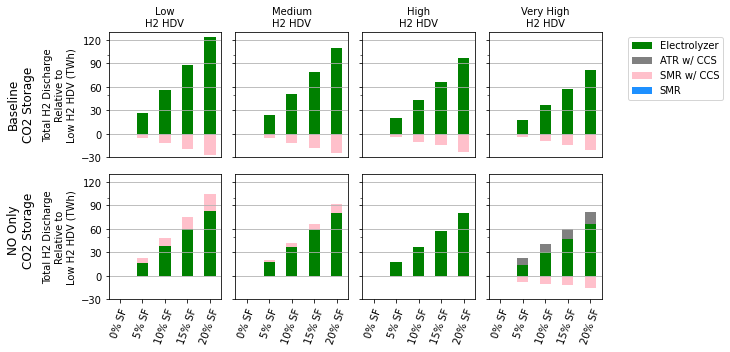

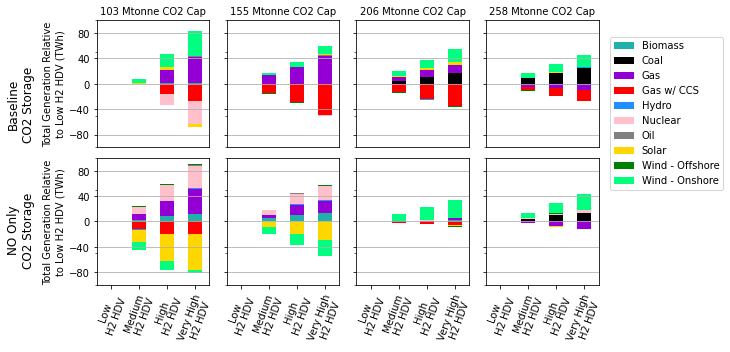

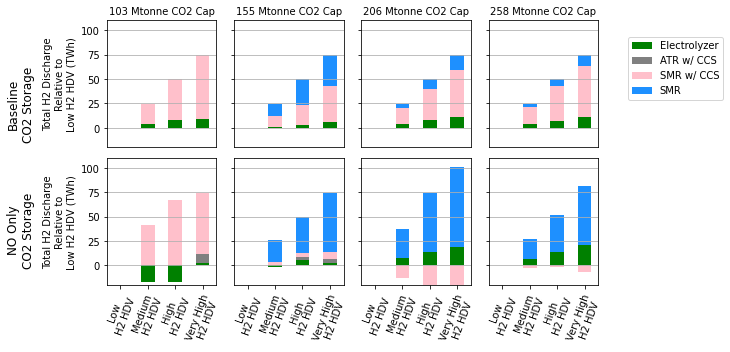

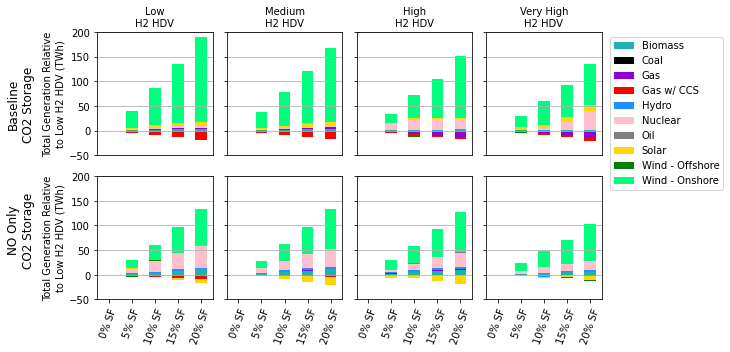

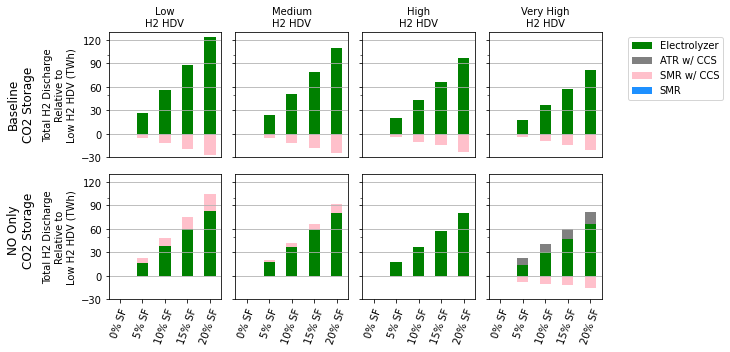

In [37]:
def compare_plot_ax(i, label, group, relative, group_by_CO2_cap, ylim, y_label, plot_type, display_legend, subplot_titles, x_label, colors, ax):
        
    reference_row = group.iloc[0]

    if relative == True:
        for col in group.columns:
            group[col] = group[col] - reference_row[col]

    # Plot the data and set the axis labels and tick labels
    artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color=colors)
    ax.set_ylabel(y_label)
    locs = ax.get_xticks()
    labels = [group.index[i] for i in range(len(group.index))]
    # Group the data based on the specified method
    if group_by_CO2_cap:
        labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
    else:
        labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]

    ax.grid(axis='y')
    if ylim == None:
        if plot_type == "elec":
            ax.set_ylim([0,3400])
            if relative:
                ax.set_ylim([-100,150])
        elif plot_type == "elec_cap" :
            ax.set_ylim([0,1500])
            if relative:
                ax.set_ylim([-50,75])
        elif plot_type == "h2":
            ax.set_ylim([0,620])
            if relative:
                ax.set_ylim([-25,100])
        else:
            ax.set_ylim([0,10])

            if relative:
                ax.set_ylim([-200,200])       
    else:
        ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    if x_label == True:
        ax.set_xticklabels(labels, rotation=70)
    else:
        ax.get_xaxis().set_ticks([])

    if display_legend == True:
        ax.set_title(subplot_titles[i], size = 10)
        
    return ax

    
def create_plots_groups(plot_type, gen_list, data_col, order, index_ordered, group_by_CO2_cap, reorder_groups):
    
    if plot_type != "fuels":
        # Concatenate and pivot the input data
        curr_df = pd.concat(gen_list).query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type')
    else: 
        curr_df = gen_list.copy()
        curr_df['fuel_cons'] = curr_df['fuel_cons'] * 2.93071e-7
        curr_df = curr_df.pivot(index='scenario', columns='Fuel')
   
    
    # Extract the desired data column and convert units
    curr_df = curr_df[data_col] * (33.3*1e9*1e-12) if plot_type == "h2" else curr_df[data_col]
  
    # Reorder and truncate the index labels
    curr_df = curr_df.reindex(index=index_ordered)
    curr_df.index = [label[:-21] for label in curr_df.index]
    
    if plot_type == "h2":
        # Reorder the columns (i.e., the resource types)
        curr_df = curr_df[order]
    
    
    # Group the data based on the specified method
    if group_by_CO2_cap:
        grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% CO2 Cap)', expand=False))#.apply(lambda x: x.sort_index())
        subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"]
        labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
    else:
        grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))
        subplot_titles = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
        labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
        
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]
    
    if reorder_groups == True:
        # Concatenate the remaining groups and the first group in reverse order
        groups_reordered = remaining_groups + [first_group]
    else:
        groups_reordered =  [first_group] + remaining_groups

    return groups_reordered, subplot_titles, labels


def fig_compare_new(dir_name, gen_list_1, gen_list_2, title_str, index_ordered_1, index_ordered_2, group_by_CO2_cap=False, 
                plot_type="elec", relative = True, scenario_save = "baseline", ylim = None,
                reorder_groups = True):    
    if plot_type == "elec":
        data_col = "generation_twh"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        if relative == True:
            y_label = "Total Generation Relative\nto Low H2 HDV (TWh)"
        else:
            y_label = "Total Generation (TWh)"
    elif plot_type == "elec_cap":
        data_col = "capacity_gw"
        y_label = "Total Capacity (TW)"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
    elif plot_type == "h2":
        data_col = "h2_prod"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        if relative == True:
            y_label = "Total H2 Discharge\nRelative to\nLow H2 HDV (TWh)"
        else:
            y_label = "Total H2 Discharge (TWh)"
    elif plot_type == "fuels":
        data_col = "fuel_cons"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        if relative == True:
            y_label = "Fossil Fuel Consumption\nRelativeto Low H2 HDV (TWh)"
        else:
            y_label = "Fossil Fuel\nConsumption (TWh)"
    else:
        raise ValueError("Invalid plot_type. Must be 'elec' or 'h2'.")
    
    if 'order' in vars():
        order = order
    else:
        order = None
    
    groups_reordered_1, subplot_titles_1, labels_1 = create_plots_groups(plot_type = plot_type,
                                                                   gen_list = gen_list_1, 
                                                                   data_col = data_col,
                                                                   order = order,
                                                                   index_ordered = index_ordered_1,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    groups_reordered_2, subplot_titles_2, labels_2 = create_plots_groups(plot_type = plot_type,
                                                                   gen_list = gen_list_2, 
                                                                   data_col = data_col,
                                                                   order = order,
                                                                   index_ordered = index_ordered_2,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    
    # Determine number of subplots based on number of groups
    num_subplots = len(groups_reordered_1)

    fig, (axes_top, axes_bottom) = plt.subplots(2, num_subplots, sharey=True, figsize=(8.05, 5))
        
    fig.subplots_adjust(top=0.30, hspace=0.5)  # Adjust the top parameter for tighter spacing
    
    # Iterate over groups and plot each group in a separate subplot
    legend_artists = []
    for i, (label, group) in enumerate(groups_reordered_1):
        
        ax = axes_top[i] if num_subplots > 1 else axes
        
        compare_plot_ax(i = i,
                        label = label,
                        group = group,
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim, 
                        y_label = y_label,
                        plot_type = plot_type,
                        display_legend = True,
                        subplot_titles = subplot_titles_1,
                        x_label = False,
                        colors = colors,
                        ax = ax)
        
    for i, (label, group) in enumerate(groups_reordered_2):
        
        ax = axes_bottom[i] if num_subplots > 1 else axes
        
        compare_plot_ax(i = i,
                        label = label,
                        group = group,
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim, 
                        y_label = y_label,
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles_2,
                        x_label = True,
                        colors = colors,
                        ax = ax)

    # Set overall figure title and legend
    #fig.suptitle(title_str, fontsize=14)
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.2,0.9))
    
    plt.tight_layout(rect=[0, 0.03, 1.1, 0.95]) 
    plt.tight_layout()
    
    
    fig.text(-0.02, 0.7, "Baseline\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')
    fig.text(-0.02, 0.35, "NO Only\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')

    if plot_type == "elec":  
        plt.savefig(dir_name + 'Figures/elec_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "h2":
        plt.savefig(dir_name + 'Figures/h2_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "fuels":
        plt.savefig(dir_name + 'Figures/fuels_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
        
    
    return fig  
        
    
fig_compare_new(directory_name,DATA_POWER_baseline[0], DATA_POWER_no_only[0],  "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_baseline_vals, index_ordered_2 = s1_scenario_list_no_only_vals,
                group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "dual_rel" , ylim = [-100, 100], reorder_groups = True)

fig_compare_new(directory_name,DATA_H2_baseline[0], DATA_H2_no_only[0],  "H2 Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_baseline_vals, index_ordered_2 = s1_scenario_list_no_only_vals,
                group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "dual_rel" , ylim = [-20, 110], reorder_groups = True)

fig_compare_new(directory_name,DATA_POWER_sf_baseline[0], DATA_POWER_sf_no_only[0],  "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                    index_ordered_1 = s1_scenario_list_sf_baseline_vals,index_ordered_2 = s1_scenario_list_sf_no_only_vals,
                group_by_CO2_cap = False, 
                plot_type = "elec", relative = True, scenario_save = "sf_dual_rel" , ylim = [-50, 200], reorder_groups = False)


fig_compare_new(directory_name,DATA_H2_sf_baseline[0], DATA_H2_sf_no_only[0],  "H2 Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_sf_baseline_vals,index_ordered_2 = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "h2", relative = True, scenario_save = "sf_dual_rel" , ylim = [-30, 130], reorder_groups = False)

In [ ]:
def compare_plot_ax(i, label, group, relative, group_by_CO2_cap, ylim, y_label, plot_type, display_legend, subplot_titles, x_label, colors, ax):
        
    # Plot the data and set the axis labels and tick labels
    artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color=colors)
    if y_label != None:
        ax.set_ylabel(y_label)
    else:
        ax.get_yaxis().set_ticks([])
        ax.yaxis.set_tick_params(labelleft=False)
    locs = ax.get_xticks()
    labels = [group.index[i] for i in range(len(group.index))]
    # Group the data based on the specified method
    
    labels = ["103 Mtonne", "155 Mtonne", "206 Mtonne", "258 Mtonne"]

    ax.grid(axis='y')
 
    ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    if x_label == True:
        ax.set_xticklabels(labels, rotation=70)
        ax.set_xlabel("CO2 Cap")
    else:
        ax.get_xaxis().set_ticks([])

    if display_legend == True:
        ax.set_title(subplot_titles, size = 12)
        
    return ax

    
def create_plots_groups(plot_type, gen_list, order, index_ordered, group_by_CO2_cap, reorder_groups):
    
    if plot_type == "elec":
        data_col = "generation_twh"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        y_label = "Total Power\nGeneration (TWh)"
    elif plot_type == "elec_cap":
        data_col = "capacity_gw"
        y_label = "Total PowerCapacity (TW)"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
    elif plot_type == "h2":
        data_col = "h2_prod"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        y_label = "Total H2 Discharge (TWh)"
    elif plot_type == "h2_cap":
        data_col = "EndCap"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        y_label = "Total H2 Capacity (TW)"
    elif plot_type == "fuels":
        data_col = "fuel_cons"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        y_label = "Fossil Fuel\nConsumption (TWh)"
    else:
        raise ValueError("Invalid plot_type. Must be 'elec' or 'h2'.")
    
    
    if plot_type != "fuels":
        # Concatenate and pivot the input data
        curr_df = pd.concat(gen_list).query("h2_percent == '0.2'").query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type')
    else: 
        curr_df = gen_list.copy()
        curr_df['fuel_cons'] = curr_df['fuel_cons'] * 2.93071e-7
        curr_df = curr_df.pivot(index='scenario', columns='Fuel')
    
    # Extract the desired data column and convert units
    if plot_type == "h2":
        curr_df = curr_df[data_col] * (33.3*1e9*1e-12) 
    elif plot_type == "h2_cap":
        curr_df = curr_df[data_col] * (33.3*1e-3) 
    else:
        curr_df = curr_df[data_col]
    
    #curr_df = curr_df[data_col] * (1e3) if (plot_type == "h2_cap") else curr_df[data_col]
  
    # Reorder and truncate the index labels
    curr_df = curr_df.reindex(index=index_ordered)
    curr_df.index = [label[:-21] for label in curr_df.index]
    
    if plot_type == "h2" or plot_type == "h2_cap":
        # Reorder the columns (i.e., the resource types)
        curr_df = curr_df[order]
   
    grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))
    subplot_titles = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
    labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
        
    
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]
    groups_reordered =  [first_group] + remaining_groups

    return groups_reordered, subplot_titles, labels, colors


def fig_compare_new(dir_name, gen_list_1, gen_list_2,h2_list_1, h2_list_2, title_str, index_ordered_1, index_ordered_2, group_by_CO2_cap=False, 
                plot_type="elec", relative = True, scenario_save = "baseline", ylim_1 = None,ylim_2 = None,ylim_3 = None,ylim_4 = None,
                reorder_groups = True):    
    
    
    if 'order' in vars():
        order = order
    else:
        order = None
    
    groups_reordered_1, subplot_titles_1, labels_1, colors_1 = create_plots_groups(plot_type = plot_type,
                                                                   gen_list = gen_list_1[0],
                                                                   order = order,
                                                                   index_ordered = index_ordered_1,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    groups_reordered_2, subplot_titles_2, labels_2, colors_2 = create_plots_groups(plot_type = plot_type,
                                                                   gen_list = gen_list_2[0],
                                                                   order = order,
                                                                   index_ordered = index_ordered_2,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    groups_reordered_5, subplot_titles_5, labels_1, colors_1 = create_plots_groups(plot_type = "elec_cap",
                                                                   gen_list = gen_list_1[1],
                                                                   order = order,
                                                                   index_ordered = index_ordered_1,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    groups_reordered_6, subplot_titles_6, labels_2, colors_2 = create_plots_groups(plot_type = "elec_cap",
                                                                   gen_list = gen_list_2[1],
                                                                   order = order,
                                                                   index_ordered = index_ordered_2,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    groups_reordered_3, subplot_titles_1, labels_1, colors_3 = create_plots_groups(plot_type = 'h2',
                                                                   gen_list = h2_list_1[0], 
                                                                   order = order,
                                                                   index_ordered = index_ordered_1,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    groups_reordered_4, subplot_titles_2, labels_2, colors_4 = create_plots_groups(plot_type = 'h2',
                                                                   gen_list = h2_list_2[0],
                                                                   order = order,
                                                                   index_ordered = index_ordered_2,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    groups_reordered_7, subplot_titles_1, labels_1, colors_3 = create_plots_groups(plot_type = 'h2_cap',
                                                                   gen_list = h2_list_1[1], 
                                                                   order = order,
                                                                   index_ordered = index_ordered_1,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    groups_reordered_8, subplot_titles_2, labels_2, colors_4 = create_plots_groups(plot_type = 'h2_cap',
                                                                   gen_list = h2_list_2[1],
                                                                   order = order,
                                                                   index_ordered = index_ordered_2,
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
    
    
    # Determine number of subplots based on number of groups
    num_subplots = len(groups_reordered_1)

    fig, (axes_r1, axes_r2, axes_r3, axes_r4) = plt.subplots(4, 2,figsize=(6, 8))
        
    #fig.subplots_adjust(top=0.30, hspace=0.5)  # Adjust the top parameter for tighter spacing
    
    # Iterate over groups and plot each group in a separate subplot
    legend_artists = []
    
    compare_plot_ax(i = 0,
                        label = "Generation",
                        group = groups_reordered_1[0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_1, 
                        y_label = "Power Generation\n(TWh)",
                        plot_type = plot_type,
                        display_legend = True,
                        subplot_titles = "Baseline CO2 Storage",
                        x_label = False,
                        colors = colors_1,
                        ax = axes_r1[0])
    
    compare_plot_ax(i = 0,
                        label = "Generation",
                        group = groups_reordered_2[0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_1, 
                        y_label = None,
                        plot_type = plot_type,
                        display_legend = True,
                        subplot_titles = "NO Only CO2 Storage",
                        x_label = False,
                        colors = colors_2,
                        ax = axes_r1[1])
    
    compare_plot_ax(i = 0,
                        label = "Generation",
                        group = groups_reordered_5[0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_2, 
                        y_label = "Power Capacity\n(GW)",
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles_1,
                        x_label = False,
                        colors = colors_1,
                        ax = axes_r2[0])
    
    compare_plot_ax(i = 0,
                        label = "Generation",
                        group = groups_reordered_6[0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_2, 
                        y_label = None,
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles_1,
                        x_label = False,
                        colors = colors_2,
                        ax = axes_r2[1])
    
    
    compare_plot_ax(i = 0,
                        label = "Generation",
                        group = groups_reordered_3[0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_3, 
                        y_label = "H2 Generation\n(TWh)",
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles_1,
                        x_label = False,
                        colors = colors_3,
                        ax = axes_r3[0])
    
    compare_plot_ax(i = 0,
                        label = "Generation",
                        group = groups_reordered_4[0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_3, 
                        y_label = None,
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles_1,
                        x_label = False,
                        colors = colors_4,
                        ax = axes_r3[1])
        
    
    
    compare_plot_ax(i = 0,
                        label = "Generation",
                        group = groups_reordered_7[0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_4, 
                        y_label = "H2 Capacity\n(GW)",
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles_1,
                        x_label = True,
                        colors = colors_3,
                        ax = axes_r4[0])
    
    compare_plot_ax(i = 0,
                        label = "Generation",
                        group = groups_reordered_8[0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_4, 
                        y_label = None,
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles_1,
                        x_label = True,
                        colors = colors_4,
                        ax = axes_r4[1])
    
        
    # Set overall figure title and legend
    fig.suptitle(title_str, fontsize=14)
    
    handles, labels = axes_r1[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.26,0.90))
    
    plt.tight_layout(rect=[0, 0.03, 1.1, 0.95]) 
    plt.tight_layout()
    
    handles, labels = axes_r3[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.23,0.52))

    if plot_type == "elec":  
        plt.savefig(dir_name + 'Figures/elec_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "h2":
        plt.savefig(dir_name + 'Figures/h2_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "fuels":
        plt.savefig(dir_name + 'Figures/fuels_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
        
    
    return fig  
        
    
fig_compare_new(directory_name,DATA_POWER_baseline, DATA_POWER_no_only, DATA_H2_baseline, DATA_H2_no_only,  "Absolute Power and Hydrogen Generation and Capacity \n For Low H2 HDV Adoption Across Emission Cap Scenarios", index_ordered_1 = s1_scenario_list_baseline_vals,
            index_ordered_2 = s1_scenario_list_baseline_vals, group_by_CO2_cap = False, plot_type = "elec", relative = False, scenario_save = "dual_rel" , ylim_1 = [0, 3300],ylim_2 = [0, 2000], 
                ylim_3 = [0, 550], ylim_4 = [0, 100], reorder_groups = True)

In [ ]:
#pd.concat(DATA_POWER_baseline[0]).query("co2_percent == '0.4'")

curr_df = pd.concat(DATA_POWER_baseline[1]).query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type')
curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))
curr_df

#pd.concat(DATA_POWER_baseline[0]).query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type').columns

In [ ]:
DATA_H2_sf_no_only[0]

In [ ]:
def fig_compare(dir_name, gen_list, title_str, index_ordered, group_by_CO2_cap=False, 
                plot_type="elec", relative = True, scenario_save = "baseline", ylim = None,
                reorder_groups = True, super_ylabel = None, display_legend = True,
                x_label = True):    
    if plot_type == "elec":
        data_col = "generation_twh"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        if relative == True:
            y_label = "Total Generation Relative\nto Low H2 HDV (TWh)"
        else:
            y_label = "Total Generation (TWh)"
    elif plot_type == "elec_cap":
        data_col = "capacity_gw"
        y_label = "Total Capacity (TW)"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
    elif plot_type == "h2":
        data_col = "h2_prod"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        if relative == True:
            y_label = "Total H2 Discharge Relative\nto Low H2 HDV (TWh)"
        else:
            y_label = "Total H2 Discharge (TWh)"
    elif plot_type == "fuels":
        data_col = "fuel_cons"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        if relative == True:
            y_label = "Fossil Fuel Consumption\nRelativeto Low H2 HDV (TWh)"
        else:
            y_label = "Fossil Fuel\nConsumption (TWh)"
    else:
        raise ValueError("Invalid plot_type. Must be 'elec' or 'h2'.")
    
    if plot_type != "fuels":
        # Concatenate and pivot the input data
        curr_df = pd.concat(gen_list).query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type')
    else: 
        curr_df = gen_list.copy()
        curr_df['fuel_cons'] = curr_df['fuel_cons'] * 2.93071e-7
        curr_df = curr_df.pivot(index='scenario', columns='Fuel')
   
    # Extract the desired data column and convert units
    curr_df = curr_df[data_col] * (33.3*1e9*1e-12) if plot_type == "h2" else curr_df[data_col]
  
    # Reorder and truncate the index labels
    curr_df = curr_df.reindex(index=index_ordered)
    curr_df.index = [label[:-21] for label in curr_df.index]
    
    if plot_type == "h2":
        # Reorder the columns (i.e., the resource types)
        curr_df = curr_df[order]
    
    # Group the data based on the specified method
    if group_by_CO2_cap:
        grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% CO2 Cap)', expand=False))#.apply(lambda x: x.sort_index())
        subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"]
        labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
    else:
        grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))
        subplot_titles = ["20% H2", "40% H2", "60% H2", "80% H2"]
        labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]

    # Determine number of subplots based on number of groups
    num_subplots = len(grouped_df)

    if x_label == True:
        # Create subplots with shared y-axis and adjust spacing
        fig, axes = plt.subplots(1, num_subplots, sharey=True, figsize=(8.05, 2.9))
    else:
        fig, axes = plt.subplots(1, num_subplots, sharey=True, figsize=(8, 2.3))
        
    fig.subplots_adjust(top=0.30, hspace=0.5)  # Adjust the top parameter for tighter spacing
    
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]
    
    if reorder_groups == True:
        # Concatenate the remaining groups and the first group in reverse order
        groups_reordered = remaining_groups + [first_group]
    else:
        groups_reordered =  [first_group] + remaining_groups
    
    # Iterate over groups and plot each group in a separate subplot
    legend_artists = []
    for i, (label, group) in enumerate(groups_reordered):
        
        reference_row = group.iloc[0]
        
        if relative == True:
            for col in group.columns:
                group[col] = group[col] - reference_row[col]

        ax = axes[i] if num_subplots > 1 else axes  # Use appropriate subplot if there is only one group
        
        # Plot the data and set the axis labels and tick labels
        artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color=colors)
        ax.set_ylabel(y_label)
        locs = ax.get_xticks()
        labels = [group.index[i] for i in range(len(group.index))]
        # Group the data based on the specified method
        if group_by_CO2_cap:
            labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
        else:
            labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
        
        ax.grid(axis='y')
        if ylim == None:
            if plot_type == "elec":
                ax.set_ylim([0,3400])
                if relative:
                    ax.set_ylim([-100,150])
            elif plot_type == "elec_cap" :
                ax.set_ylim([0,1500])
                if relative:
                    ax.set_ylim([-50,75])
            elif plot_type == "h2":
                ax.set_ylim([0,620])
                if relative:
                    ax.set_ylim([-25,100])
            else:
                ax.set_ylim([0,10])

                if relative:
                    ax.set_ylim([-200,200])       
        else:
            ax.set_ylim(ylim)
            
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))
        
        if x_label == True:
            ax.set_xticklabels(labels, rotation=70)
        else:
            ax.get_xaxis().set_ticks([])
            
        if display_legend == True:
            ax.set_title(subplot_titles[i], size = 10)

    # Set overall figure title and legend
    fig.suptitle(title_str, fontsize=14)
    
    if display_legend == True:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor= (1.2,1))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.tight_layout()
    
    if super_ylabel != None:
        fig.text(-0.02, 0.6, super_ylabel, rotation="vertical", va="center", fontsize=12, ha = 'center')

    if plot_type == "elec":  
        plt.savefig(dir_name + 'Figures/elec_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "h2":
        plt.savefig(dir_name + 'Figures/h2_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "fuels":
        plt.savefig(dir_name + 'Figures/fuels_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
        
    
    return fig  
        

In [ ]:
fig_compare(directory_name,DATA_POWER_baseline[0], "", index_ordered = s1_scenario_list_baseline_vals,
            group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "baseline_rel" , ylim = [-100, 100], reorder_groups = True, 
            display_legend = True, x_label= False, super_ylabel = "Baseline\nCO2 Storage")

fig_compare(directory_name,DATA_POWER_no_only[0], "", index_ordered = s1_scenario_list_no_only_vals,
            group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "no_only_rel" , ylim = [-100, 100], reorder_groups = True,
           display_legend = False, x_label= True, super_ylabel = "NO Only\nCO2 Storage")

fig_compare(directory_name,DATA_H2_baseline[0], "", index_ordered = s1_scenario_list_baseline_vals,
            group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "baseline_rel" , ylim = [-30, 110], reorder_groups = True, 
            display_legend = True, x_label= False, super_ylabel = "Baseline\nCO2 Storage")

fig_compare(directory_name,DATA_H2_no_only[0], "", index_ordered = s1_scenario_list_no_only_vals,
            group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "no_only_rel" , ylim = [-30, 110], reorder_groups = True,
           display_legend = False, x_label= True, super_ylabel = "NO Only\nCO2 Storage")


In [ ]:
fig_compare(directory_name,DATA_POWER_baseline[0], "Power Generation by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals,
            group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "baseline", reorder_groups = True)
fig_compare(directory_name,DATA_POWER_baseline[0], "Power Generation by Type Relative - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals,
            group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "baseline_rel" , ylim = [-100, 100], reorder_groups = True)

fig_compare(directory_name,DATA_H2_baseline[0], "H2 Generation by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals,
            group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "baseline" , ylim = [0,700], reorder_groups = True)
fig_compare(directory_name,DATA_H2_baseline[0], "H2 Generation by Type Relative- Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals,
            group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "baseline_rel" , ylim = [-40, 110], reorder_groups = True)

fig_compare(directory_name,DATA_FUEL_baseline, "Fossil Fuel Consumption - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals,
            group_by_CO2_cap = True, plot_type = "fuels", relative = False, scenario_save = "baseline" , ylim = [0,2000], reorder_groups = True)
fig_compare(directory_name,DATA_FUEL_baseline, "Fossil Fuel Consumption - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals,
            group_by_CO2_cap = True, plot_type = "fuels", relative = True, scenario_save = "baseline_rel" , ylim = [-100, 50], reorder_groups = True)

fig_compare(directory_name,DATA_POWER_no_only[0], "Power Generation by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals,
            group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "no_only", reorder_groups = True)
fig_compare(directory_name,DATA_POWER_no_only[0], "Power Generation by Type Relative - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals,
            group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "no_only_rel" , ylim = [-100, 100], reorder_groups = True)

fig_compare(directory_name,DATA_H2_no_only[0], "H2 Generation by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals,
            group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "no_only" , ylim = [0,700], reorder_groups = True)
fig_compare(directory_name,DATA_H2_no_only[0], "H2 Generation by Type Relative - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals,
            group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "no_only_rel" , ylim = [-40, 110], reorder_groups = True)

fig_compare(directory_name,DATA_FUEL_no_only, "Fossil Fuel Consumption - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals,
            group_by_CO2_cap = True, plot_type = "fuels", relative = False, scenario_save = "no_only" , ylim = [0,2000], reorder_groups = True)
fig_compare(directory_name,DATA_FUEL_no_only, "Fossil Fuel Consumption - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals,
            group_by_CO2_cap = True, plot_type = "fuels", relative = True, scenario_save = "no_only_rel" , ylim = [-100, 50], reorder_groups = True)

In [ ]:
fig_compare(directory_name_sf,DATA_POWER_sf_baseline[0], "Power Generation by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_sf_baseline_vals,
            group_by_CO2_cap = False, plot_type = "elec", relative = False, scenario_save = "sf_baseline", reorder_groups = False)
fig_compare(directory_name_sf,DATA_POWER_sf_baseline[0], "Power Generation by Type Relative - Baseline CO2 Storage", index_ordered = s1_scenario_list_sf_baseline_vals,
            group_by_CO2_cap = False, plot_type = "elec", relative = True, scenario_save = "sf_baseline_rel" , ylim = [-50, 200], reorder_groups = False)

fig_compare(directory_name_sf,DATA_H2_sf_baseline[0], "H2 Generation by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_sf_baseline_vals,
            group_by_CO2_cap = False, plot_type = "h2", relative = False, scenario_save = "sf_baseline" , ylim = [0,700], reorder_groups = False)
fig_compare(directory_name_sf,DATA_H2_sf_baseline[0], "H2 Generation by Type Relative- Baseline CO2 Storage", index_ordered = s1_scenario_list_sf_baseline_vals,
            group_by_CO2_cap = False, plot_type = "h2", relative = True, scenario_save = "sf_baseline_rel" , ylim = [-50, 150], reorder_groups = False)

fig_compare(directory_name_sf,DATA_FUEL_sf_baseline, "Fossil Fuel Consumption - Baseline CO2 Storage", index_ordered = s1_scenario_list_sf_baseline_vals,
            group_by_CO2_cap = False, plot_type = "fuels", relative = False, scenario_save = "sf_baseline" , ylim = [0,2000], reorder_groups = False)
fig_compare(directory_name_sf,DATA_FUEL_sf_baseline, "Fossil Fuel Consumption - Baseline CO2 Storage", index_ordered = s1_scenario_list_sf_baseline_vals,
            group_by_CO2_cap = False, plot_type = "fuels", relative = True, scenario_save = "sf_baseline_rel" , ylim = [-100, 50], reorder_groups = False)

fig_compare(directory_name_sf,DATA_POWER_sf_no_only[0], "Power Generation by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "elec", relative = False, scenario_save = "sf_no_only", reorder_groups = False)
fig_compare(directory_name_sf,DATA_POWER_sf_no_only[0], "Power Generation by Type Relative - NO Only CO2 Storage", index_ordered = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "elec", relative = True, scenario_save = "sf_no_only_rel" , ylim = [-50, 200], reorder_groups = False)

fig_compare(directory_name_sf,DATA_H2_sf_no_only[0], "H2 Generation by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "h2", relative = False, scenario_save = "sf_no_only" , ylim = [0,700], reorder_groups = False)
fig_compare(directory_name_sf,DATA_H2_sf_no_only[0], "H2 Generation by Type Relative - NO Only CO2 Storage", index_ordered = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "h2", relative = True, scenario_save = "sf_no_only_rel" , ylim = [-50, 150], reorder_groups = False)

fig_compare(directory_name_sf,DATA_FUEL_sf_no_only, "Fossil Fuel Consumption - NO Only CO2 Storage", index_ordered = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "fuels", relative = False, scenario_save = "sf_no_only" , ylim = [0,2000], reorder_groups = False)
fig_compare(directory_name_sf,DATA_FUEL_sf_no_only, "Fossil Fuel Consumption - NO Only CO2 Storage", index_ordered = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "fuels", relative = True, scenario_save = "sf_no_only_rel" , ylim = [-100, 50], reorder_groups = False)

In [ ]:
        
fig_power_gen_baseline = fig_compare(directory_name,DATA_POWER_baseline[0], "Power Generation by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "baseline")
fig_power_gen_limited = fig_compare(directory_name,DATA_POWER_limited[0], "Power Generation by Type - Limited CO2 Storage", index_ordered = s1_scenario_list_limited_vals, group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save ="limited")
fig_power_gen_no_only = fig_compare(directory_name,DATA_POWER_no_only[0], "Power Generation by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals, group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save ="no_only")


fig_compare(directory_name,DATA_POWER_baseline[0], "Power Generation by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save ="baseline_rel")
#fig_compare(directory_name,DATA_POWER_limited[0], "Power Generation by Type - Limited CO2 Storage", index_ordered = s1_scenario_list_limited_vals, group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save ="limited_rel")
fig_compare(directory_name,DATA_POWER_no_only[0], "Power Generation by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals, group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save ="non_only_rel")


fig_compare(directory_name,DATA_H2_baseline[0], "H2 Generation by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save ="baseline")
#fig_compare(directory_name,DATA_H2_limited[0], "H2 Generation by Type - Limited CO2 Storage", index_ordered = s1_scenario_list_limited_vals, group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save ="limited")
fig_compare(directory_name,DATA_H2_no_only[0], "H2 Generation by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals, group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save ="no_only")

fig_compare(directory_name,DATA_H2_baseline[0], "H2 Generation by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save ="baseline_rel")
#fig_compare(directory_name,DATA_H2_limited[0], "H2 Generation by Type - Limited CO2 Storage", index_ordered = s1_scenario_list_limited_vals, group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save ="limited_rel")
fig_compare(directory_name,DATA_H2_no_only[0], "H2 Generation by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_no_only_vals, group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save ="no_only_rel")


fig_compare(directory_name,DATA_FUEL_baseline, "Fossil Fuel Consumption - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "fuels", relative = True, scenario_save = "baseline")
#fig_compare(directory_name,DATA_FUEL_limited, "Fossil Fuel Consumption - Limited CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "fuels", relative = True, scenario_save = "baseline")
fig_compare(directory_name,DATA_FUEL_no_only, "Fossil Fuel Consumption - NO Only CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "fuels", relative = True, scenario_save = "no_only")



In [ ]:
# Create a combined figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Save the figures and load them using imread
fig_power_gen_baseline.savefig(directory_name + '/Figures/fig1.png', dpi=600)
fig_power_gen_baseline.savefig(directory_name + '/Figures/fig2.png', dpi=600)
image1 = plt.imread(directory_name + '/Figures/fig1.png')
image2 = plt.imread(directory_name + '/Figures/fig2.png')

# Display the figures in the subplots
axes[0].imshow(image1)
axes[0].axis('off')
axes[1].imshow(image2)
axes[1].axis('off')

plt.subplots_adjust(hspace=0)

# Save the combined figure
plt.savefig(directory_name + '/Figures/combined_fig.png', dpi=600, bbox_inches='tight')


In [ ]:
#DATA_POWER_baseline[1]
fig_compare(directory_name,DATA_POWER_baseline[1], "Power Generation Capacity by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "baseline")
fig_compare(directory_name,DATA_POWER_limited[1], "Power Generation Capacity by Type - Limited CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "baseline")
fig_compare(directory_name,DATA_POWER_no_only[1], "Power Generation Capacity by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "baseline")
fig_compare(directory_name,DATA_POWER_baseline[1], "Power Generation Capacity by Type - Baseline CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "elec_cap", relative = True, scenario_save = "baseline")
fig_compare(directory_name,DATA_POWER_limited[1], "Power Generation Capacity by Type - Limited CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "elec_cap", relative = True, scenario_save = "baseline")
fig_compare(directory_name,DATA_POWER_no_only[1], "Power Generation Capacity by Type - NO Only CO2 Storage", index_ordered = s1_scenario_list_baseline_vals, group_by_CO2_cap = True, plot_type = "elec_cap", relative = True, scenario_save = "baseline")


In [ ]:
def prep_emissions_df(df_in, columns_to_plot, group_by_CO2_cap, reorder_groups, plot_type): 
    df = df_in.copy()
    df = df.rename(columns={'Power Plant Emissions': 'Power Plant Gross CO2 Emissions',
                           'Power Plant PSC Abatement':'Power Plant CO2 Capture ',
                           'H2 Plant Emissions':'H2 Plant Gross CO2 Emissions',
                            'H2 Plant PSC Abatement' :'H2 Plant CO2 Capture ',
                            'DAC Plant Emissions':'DAC Plant Gross Emissions',
                            'DAC Abatement':'DAC Plant CO2 Capture',
                            'sf_emissions' :  'SynFuel Emissions'})
    
    df["Power Emissions"] = df["Power Plant Gross CO2 Emissions"] + df["Power Plant CO2 Capture "]
    df["H2 Emissions"] = df["H2 Plant Gross CO2 Emissions"] + df["H2 Plant CO2 Capture "]
    df["Liqid Fuels Emissions"] = df["Conventional Fuel Emissions"] 

    df["Total CO2 Captured"] = df['Power Plant CO2 Capture '] + df['H2 Plant CO2 Capture ']
    
    if plot_type != "emissions":
        df["CO2 Storage"] = df["CO2 Storage"] + df["DAC Fuel CCS"]
        df[columns_to_plot] = df[columns_to_plot] * -1
        
    # create a new dataframe with only the selected columns
    df_stacked = df[columns_to_plot]
    if plot_type == "emissions":
        df_stacked['DAC Plant CO2 Capture'] = df_stacked['DAC Plant CO2 Capture'] #* -1
    df_stacked.index = [label[:-21] for label in df_stacked.index]
    
    df_stacked.to_csv("emissions_balance.csv")
    
     # Group the data based on the specified method
    if group_by_CO2_cap:
        grouped_df = df_stacked.groupby(df_stacked.index.str.extract('(\d+% CO2 Cap)', expand=False))#.apply(lambda x: x.sort_index())
        subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"]
        labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
    else:
        grouped_df = df_stacked.groupby(df_stacked.index.str.extract('(\d+% H2)', expand=False))#.apply(lambda x: x.sort_index())
        subplot_titles = ["20% H2", "40% H2", "60% H2", "80% H2"]
        labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
        
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]
    
    if reorder_groups == True:
        # Concatenate the remaining groups and the first group in reverse order
        groups_reordered = remaining_groups + [first_group]
    else:
        groups_reordered = [first_group] + remaining_groups 

    return groups_reordered, subplot_titles, labels

def plot_emissions_axis(ax, i, labels, x_label, group, subplot_titles, y_lim, plot_type, columns_to_plot):

    if i == 0:
        if plot_type == "emissions":
            ax.set_ylabel("Net Emissions\n(Mtonnes)")
        else: 
            ax.set_ylabel("Emissions\nCaptured\n(Mtonnes)")
    else: 
        ax.set_yticklabels([])

    if subplot_titles != None:
        ax.set_title(subplot_titles[i], size = 10)
        ax.axhline(y=float(subplot_titles[i][0:3]), color='r', linestyle='-')

    if plot_type == "emissions":    
        # Plot the data and set the axis labels and tick labels
        artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color = ["green", "orange", "black", "dodgerblue", "grey"])
    else:
        artists = group[columns_to_plot[:-1]].plot(kind='bar', stacked=True, legend = False, ax=ax, color = ["green", "orange", "dodgerblue", "grey"])
        # Add the scatter plot for CO2 Storage
        x_vals = [i for i in range(len(labels))]
        y_vals = group['CO2 Storage'].values
        ax.scatter(x_vals, y_vals*-1, c='red', marker='x', label='CO2 Sequestered')    

    locs = ax.get_xticks()
    
    ax.set_ylim(y_lim)
    ax.grid(axis='y')

    if x_label == True:
        ax.set_xticklabels(labels, rotation=80)

    ax.yaxis.set_major_locator(plt.MaxNLocator(5))      
    
    return ax


def fig_emissions_dual(df, df2, dir_name, group_by_CO2_cap,title, plot_stor = False,
                  scenario_save = "baseline", reorder_groups = False, y_lim = [-10, 280],
                  plot_type = "emissions"):

    columns_to_plot = ['Power Emissions',
                       'H2 Emissions',
                       "Conventional Fuel Emissions",
                       'DAC Plant CO2 Capture',
                      'SynFuel Emissions']
  
    columns_to_plot_capture = ['Power Plant CO2 Capture ',
                           'H2 Plant CO2 Capture ', 
                           "DAC Plant CO2 Capture",
                            "SF Plant Capture",
                            "CO2 Storage"]

    groups_reordered, subplot_titles, labels = prep_emissions_df(df, columns_to_plot,
                                                                 group_by_CO2_cap, reorder_groups, "emissions")
    groups_reordered_2, subplot_titles, labels = prep_emissions_df(df2, columns_to_plot_capture,
                                                                   group_by_CO2_cap, reorder_groups, "storage")
   
    # Determine number of subplots based on number of groups
    num_subplots = len(groups_reordered)
    
    if plot_type == "emissions":
        # Create subplots with shared y-axis and adjust spacing
        fig, axes = plt.subplots(2, num_subplots, sharex=True, figsize=(8, 4))
    else: 
        fig, axes = plt.subplots(2, num_subplots, sharex=True, figsize=(8, 4.5))
        
    # Iterate over groups and plot each group in a separate subplot
    legend_artists = []
    for i, (label, group) in enumerate(groups_reordered):
        axes[0][i] = plot_emissions_axis(ax = axes[0][i], i = i,
                                         labels = labels, x_label = False, group = group,
                                         subplot_titles = subplot_titles,
                                         y_lim = y_lim,
                                         plot_type = "emissions",
                                        columns_to_plot=columns_to_plot)
        
    for i, (label, group) in enumerate(groups_reordered_2):
        axes[0][i] = plot_emissions_axis(ax = axes[1][i], i = i,
                                         labels = labels,x_label = True, group = group,
                                         subplot_titles = None,
                                         y_lim = y_lim,
                                         plot_type = "storage",
                                        columns_to_plot=columns_to_plot)
        
    
    fig.text(-0.02, 0.7, "Baseline\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')
    fig.text(-0.02, 0.35, "NO Only\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')
        
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.32,0.85))
        
    # Set overall figure title and legend
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()

    plt.savefig(dir_name + 'Figures/co2_emissions_' + scenario_save + '.png', dpi=300, bbox_inches='tight')
    return fig 

fig_emissions_dual(df = DATA_EMISSIONS_baseline[0], df2 = DATA_EMISSIONS_baseline[0],dir_name = directory_name, group_by_CO2_cap=  True,
              title = "Emissions Breakdown by Emissions and H2 HDV Adoption Scenario",
              plot_stor = True, scenario_save = "dual_emissions", reorder_groups = True,
              y_lim = [-50, 280], plot_type="emissions")

fig_emissions_dual(df = DATA_EMISSIONS_no_only[0], df2 = DATA_EMISSIONS_no_only[0],dir_name = directory_name, group_by_CO2_cap=  True,
              title = "CO2 Sequestration and Utilization Breakdown\nby Emissions and H2 HDV Adoption Scenario",
              plot_stor = True, scenario_save = "dual_co2_storage", reorder_groups = True,
              y_lim = [0, 250], plot_type="storage")



In [41]:
DATA_EMISSIONS_sf_baseline[0]["DAC Abatement"]

20% H2, 0% SF,\n Baseline CO2 Storage    -8.604863e+00
20% H2, 5% SF,\n Baseline CO2 Storage    -1.057459e+01
20% H2, 10% SF,\n Baseline CO2 Storage   -1.273324e+01
20% H2, 15% SF,\n Baseline CO2 Storage   -1.513566e+01
20% H2, 20% SF,\n Baseline CO2 Storage   -1.744951e+01
40% H2, 0% SF,\n Baseline CO2 Storage    -7.290131e-01
40% H2, 5% SF,\n Baseline CO2 Storage    -2.470120e+00
40% H2, 10% SF,\n Baseline CO2 Storage   -4.382878e+00
40% H2, 15% SF,\n Baseline CO2 Storage   -6.547825e+00
40% H2, 20% SF,\n Baseline CO2 Storage   -8.994907e+00
60% H2, 0% SF,\n Baseline CO2 Storage    -1.535765e-05
60% H2, 5% SF,\n Baseline CO2 Storage    -8.189601e-09
60% H2, 10% SF,\n Baseline CO2 Storage   -9.972443e-07
60% H2, 15% SF,\n Baseline CO2 Storage   -5.960176e-01
60% H2, 20% SF,\n Baseline CO2 Storage   -1.780453e+00
80% H2, 0% SF,\n Baseline CO2 Storage    -3.795231e-08
80% H2, 5% SF,\n Baseline CO2 Storage    -2.992708e-06
80% H2, 10% SF,\n Baseline CO2 Storage   -5.355298e-08
80% H2, 15

In [42]:
DATA_EMISSIONS_sf_no_only[0]["DAC Abatement"]

20% H2, 0% SF,\n NO Only CO2 Storage    -24.856167
20% H2, 5% SF,\n NO Only CO2 Storage    -26.657763
20% H2, 10% SF,\n NO Only CO2 Storage   -28.909403
20% H2, 15% SF,\n NO Only CO2 Storage   -31.227779
20% H2, 20% SF,\n NO Only CO2 Storage   -33.654911
40% H2, 0% SF,\n NO Only CO2 Storage    -20.446570
40% H2, 5% SF,\n NO Only CO2 Storage    -22.321147
40% H2, 10% SF,\n NO Only CO2 Storage   -24.373556
40% H2, 15% SF,\n NO Only CO2 Storage   -26.618093
40% H2, 20% SF,\n NO Only CO2 Storage   -28.972503
60% H2, 0% SF,\n NO Only CO2 Storage    -17.742612
60% H2, 5% SF,\n NO Only CO2 Storage    -19.615842
60% H2, 10% SF,\n NO Only CO2 Storage   -21.579901
60% H2, 15% SF,\n NO Only CO2 Storage   -23.751880
60% H2, 20% SF,\n NO Only CO2 Storage   -25.720364
80% H2, 0% SF,\n NO Only CO2 Storage    -15.349878
80% H2, 5% SF,\n NO Only CO2 Storage    -16.417252
80% H2, 10% SF,\n NO Only CO2 Storage   -17.940013
80% H2, 15% SF,\n NO Only CO2 Storage   -19.062792
80% H2, 20% SF,\n NO Only CO2 S

In [ ]:
def fig_emissions(df, dir_name, group_by_CO2_cap,title, plot_stor = False,
                  scenario_save = "baseline", reorder_groups = False, top_ylim = [-10, 280],
                  bottom_ylim = [0, 200]):
    
    df = df.rename(columns={'Power Plant Emissions': 'Power Plant Gross CO2 Emissions',
                           'Power Plant PSC Abatement':'Power Plant CO2 Capture ',
                           'H2 Plant Emissions':'H2 Plant Gross CO2 Emissions',
                            'H2 Plant PSC Abatement' :'H2 Plant CO2 Capture ',
                            'DAC Plant Emissions':'DAC Plant Gross Emissions',
                            'DAC Abatement':'DAC Plant CO2 Capture',
                            'sf_emissions' :  'SynFuel Emissions'})
    
    df["Power Emissions"] = df["Power Plant Gross CO2 Emissions"] + df["Power Plant CO2 Capture "]
    df["H2 Emissions"] = df["H2 Plant Gross CO2 Emissions"] + df["H2 Plant CO2 Capture "]
    df["Liqid Fuels Emissions"] = df["Conventional Fuel Emissions"] 

    df["Total CO2 Captured"] = df['Power Plant CO2 Capture '] + df['H2 Plant CO2 Capture ']
    
    columns_to_plot = ['Power Emissions',
                       'H2 Emissions',
                       #"DAC Plant Gross Emissions",
                       #"SynDiesel Emissions", 
                       #"SynByProd Emissions",
                       "Conventional Fuel Emissions",
                       'DAC Plant CO2 Capture',
                      'SynFuel Emissions']
                       #'DAC Plant CO2 Capture']
    
    columns_to_plot_capture = [
                       'Power Plant CO2 Capture ',
                       'H2 Plant CO2 Capture ', 
                       "DAC Plant CO2 Capture",
                        "SF Plant Capture",
                        "CO2 Storage"]
    
    df["CO2 Storage"] = df["CO2 Storage"] + df["DAC Fuel CCS"]
    
    df[columns_to_plot_capture] = df[columns_to_plot_capture] * -1 
    
    
    # create a new dataframe with only the selected columns
    df_stacked = df[columns_to_plot]
    df_stacked['DAC Plant CO2 Capture'] = df_stacked['DAC Plant CO2 Capture'] * -1 
    df_stacked.index = [label[:-21] for label in df_stacked.index]
    
    
    df_stacked_capture = df[columns_to_plot_capture]
    df_stacked_capture.index = [label[:-21] for label in df_stacked_capture.index]
    
    # Group the data based on the specified method
    if group_by_CO2_cap:
        grouped_df = df_stacked.groupby(df_stacked.index.str.extract('(\d+% CO2 Cap)', expand=False))#.apply(lambda x: x.sort_index())
        grouped_df_capture = df_stacked_capture.groupby(df_stacked_capture.index.str.extract('(\d+% CO2 Cap)', expand=False))#.apply(lambda x: x.sort_index())
        subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"]
        emissions_cap = [103, 155, 206, 258]
        labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
    else:
        grouped_df = df_stacked.groupby(df_stacked.index.str.extract('(\d+% H2)', expand=False))#.apply(lambda x: x.sort_index())
        grouped_df_capture = df_stacked_capture.groupby(df_stacked_capture.index.str.extract('(\d+% H2)', expand=False))#.apply(lambda x: x.sort_index())
        subplot_titles = ['Low H2 HDV', 'Medium H2 HDV', 'High H2 HDV', 'Very High H2 HDV']
        labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
        emissions_cap = [103, 103,103,103]

   # Determine number of subplots based on number of groups
    num_subplots = len(grouped_df)
    
    if plot_stor:
        # Create subplots with shared y-axis and adjust spacing
        fig, axes = plt.subplots(2, num_subplots, sharex=True, figsize=(8, 3.5))
        fig.subplots_adjust(hspace=0.5)
    else:
        # Create subplots with shared y-axis and adjust spacing
        fig, axes = plt.subplots(1, num_subplots, sharex=True, figsize=(8, 2))
        fig.subplots_adjust(hspace=0.5)
    
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]
    
    # Split the groups into the first group and the remaining groups
    groups_capture = list(grouped_df_capture)
    first_group_capture = groups_capture[0]
    remaining_groups_capture = groups_capture[1:]
    
    if reorder_groups == True:
        # Concatenate the remaining groups and the first group in reverse order
        groups_reordered = remaining_groups + [first_group]
        # Concatenate the remaining groups and the first group in reverse order
        groups_reordered_capture = remaining_groups_capture + [first_group_capture]
    else:
        groups_reordered = [first_group] + remaining_groups 
        groups_reordered_capture = [first_group_capture] + remaining_groups_capture 
        
    # Iterate over groups and plot each group in a separate subplot
    legend_artists = []
    for i, (label, group) in enumerate(groups_reordered):
        if plot_stor:
            ax = axes[0][i] if num_subplots > 1 else axes  # Use appropriate subplot if there is only one group
        else:
            ax = axes[i]
        
        if i == 0:
            ax.set_ylabel("Emissions\n(Mtonnes)")
        else: 
            ax.set_yticklabels([])
            
        ax.set_title(subplot_titles[i], size = 10)
        ax.axhline(y=emissions_cap[i], color='r', linestyle='-', label = "Emissions Cap")
        
        # Plot the data and set the axis labels and tick labels
        artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color = ["green", "orange", "black", "dodgerblue", "grey"])
        locs = ax.get_xticks()
        labels = [group.index[i] for i in range(len(group.index))]

        ax.set_ylim(top_ylim)
        ax.grid(axis='y')
        
        if plot_stor == False:
            ax.set_xticklabels(labels, rotation=80)
            
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        
    handles, labels = ax.get_legend_handles_labels()
    
    # Get handles and labels for all subplots
    all_handles, all_labels = [], []
    for ax in axes[0]:
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)

    # Customize the order of labels and handles in the legend
    legend_order = [0,5,3,2,1,4]  # Customize the order as per your requirement
    handles_to_show = [all_handles[idx] for idx in legend_order]
    labels_to_show = [all_labels[idx] for idx in legend_order]

    # Create the legend with custom order
    fig.legend(handles_to_show, labels_to_show, bbox_to_anchor=(1.32,0.89))

      
    if plot_stor:
        for i, (label, group) in enumerate(groups_reordered_capture):
            ax = axes[1][i] if num_subplots > 1 else axes  # Use appropriate subplot if there is only one group

            if i == 0:
                ax.set_ylabel("Emissions\nCaptured\n(Mtonnes)")
            else: 
                ax.set_yticklabels([])

            artists = group[columns_to_plot_capture[:-1]].plot(kind='bar', stacked=True, legend = False, ax=ax, color = ["green", "orange", "dodgerblue", "grey"])
            locs = ax.get_xticks()

            # Group the data based on the specified method
            if group_by_CO2_cap:
                  labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
            else:
                  labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]

            # Add the scatter plot for CO2 Storage
            x_vals = [i for i in range(len(labels))]
            y_vals = group['CO2 Storage'].values
            ax.scatter(x_vals, y_vals*-1, c='red', marker='x', label='CO2 Sequestered')            
            ax.set_xticklabels(labels, rotation=80)
            ax.set_ylim(bottom_ylim)
            ax.grid(axis='y')
            
            ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            
    # Get handles and labels for all subplots
    all_handles, all_labels = [], []
    for ax in axes[1]:
        handles, labels = ax.get_legend_handles_labels()
        all_handles.extend(handles)
        all_labels.extend(labels)

    # Customize the order of labels and handles in the legend
    legend_order = [0,3,2,1,4]  # Customize the order as per your requirement
    handles_to_show = [all_handles[idx] for idx in legend_order]
    labels_to_show = [all_labels[idx] for idx in legend_order]
            
    fig.legend(handles_to_show, labels_to_show, bbox_to_anchor= (1.295,0.50))
        
    # Set overall figure title and legend
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()

    plt.savefig(dir_name + 'Figures/co2_emissions_' + scenario_save + '.png', dpi=300, bbox_inches='tight')
    return fig 

fig_emissions(df = DATA_EMISSIONS_baseline[0], dir_name = directory_name, group_by_CO2_cap=  True,
              title = "Emissions Breakdown by Scenario - Baseline CO2 Storage",
              plot_stor = True, scenario_save = "baseline", reorder_groups = True,
             top_ylim = [-50, 280], bottom_ylim = [0, 250])

fig_emissions(df = DATA_EMISSIONS_no_only[0], dir_name = directory_name, group_by_CO2_cap=  True,
              title = "Emissions Breakdown by Scenario - NO Only CO2 Storage",
              plot_stor = True, scenario_save = "nononly", reorder_groups = True,
             top_ylim = [-50, 280], bottom_ylim = [0, 250])

fig_emissions(df = DATA_EMISSIONS_sf_baseline[0], dir_name = directory_name, group_by_CO2_cap=  False,
             title = "Emissions Breakdown by Scenario - Baseline CO2 Storage",
             plot_stor = True, scenario_save = "baseline_sf", reorder_groups = False,
           top_ylim = [-40, 160], bottom_ylim = [0, 250])

fig_emissions(df = DATA_EMISSIONS_sf_no_only[0], dir_name = directory_name, group_by_CO2_cap=  False,
             title = "Emissions Breakdown by Scenario - NO Only CO2 Storage",
             plot_stor = True, scenario_save = "noonly_sf", reorder_groups = False,
           top_ylim = [-40, 160], bottom_ylim = [0, 250])

#fig_emissions(df = DATA_EMISSIONS_sf_no_only[0], dir_name = directory_name, group_by_CO2_cap=  False,
#              title = "Emissions Breakdown by Scenario - NO Only CO2 Storage",
#              plot_stor = True, scenario_save = "nononly_sf", reorder_groups = False,
#             top_ylim = [-50, 150], bottom_ylim = [0, 100])


#fig_emissions(DATA_EMISSIONS_baseline[0], directory_name, True,
#              "Emissions Breakdown by Scenario - Baseline CO2 Storage", True, "baseline")
#fig_emissions(DATA_EMISSIONS_no_only[0], directory_name, True, "Emissions Breakdown by Scenario - NO Only CO2 Storage", True, "no_only")
#fig_emissions(DATA_EMISSIONS_limited[0], directory_name,  True, "Emissions Breakdown by Scenario - Limited CO2 Storage", True, "no_only" )


In [ ]:
fig_emissions(df = DATA_EMISSIONS_sf_baseline[0], dir_name = directory_name, group_by_CO2_cap=  False,
              title = "Emissions Breakdown by Scenario - Baseline CO2 Storage",
              plot_stor = True, scenario_save = "baseline", reorder_groups = False,
             top_ylim = [-30, 140], bottom_ylim = [0, 250])
DATA_COST_sf_baseline

In [ ]:
DATA_EMISSIONS_sf_baseline[0].to_csv("synfuels balance.csv")

In [ ]:
DATA_EMISSIONS_sf_baseline[0]

In [ ]:
def normalize_costs(df, scenario_name):
    # Create a copy of the DataFrame
    df_copy = df.copy()

    # Get the row for the reference scenario
    reference_row = df_copy[df_copy['scenario_name'] == scenario_name].iloc[0]

    # List of columns to normalize
    cost_columns = ['total_cost', 'Power', 'H2', 'CO2', 'ConvFuels', 'SynFuels']

    # Normalize the columns by the reference scenario
    for col in cost_columns:
        df_copy[col] = df_copy[col] - reference_row[col]

    return df_copy

    
def plot_stacked_bar(df, error_bars, title, dir_name, relative = False, save_name = 'baseline', group_by = 'CO2', ylim = [0,15]):
    # extract columns for stacking
    stack_cols = ['Power', 'H2', 'CO2', 'ConvFuels','SynFuels']
    
    if group_by == 'CO2':
        subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"]
        labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
        group_col = 'co2_percent'
        y_axis_label = 'Total Cost Relative to\n Low H2 HDV (EUR Billion)'
    else:
        subplot_titles = ["20% H2", "40% H2", "60% H2", "80% H2"]
        labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
        group_col = 'h2_percent'
        y_axis_label = 'Total Cost Relative to\n No SF (EUR Billion)'
        
    iterate_vec = df[group_col].unique().tolist()
    
    # create subplots for each co2 percent
    fig, axes = plt.subplots(nrows=1, ncols=len(iterate_vec), sharey=True, figsize=(8,1.8))
    
    #df = normalize_costs(df_org, "80% H2, 40% CO2 Cap,\n Baseline CO2 Storage")
    
    # loop through co2 percents and plot stacked bar chart on corresponding subplot
    for i, curr_mask in enumerate(iterate_vec):
        # filter dataframe based on desired co2_percent
        filtered_df = df[df[group_col] == str(curr_mask)]
        
        if relative == False:
            filtered_df["H2"] = filtered_df["H2"] + error_bars
        
        if group_by == 'CO2':
            reference_row = filtered_df[filtered_df['h2_percent'] == "0.2"].iloc[0]
        else:
            reference_row = filtered_df[filtered_df['sf_percent'] == 0.0].iloc[0]
            
        # List of columns to normalize
        cost_columns = ['total_cost', 'Power', 'H2', 'CO2', 'ConvFuels', 'SynFuels']
        
        if relative: 
            cost_change_percent = filtered_df["total_cost"] - reference_row["total_cost"] 
            
            # Normalize the columns by the reference scenario
            for col in cost_columns:
                filtered_df[col] = filtered_df[col] - reference_row[col]

        # plot stacked bar chart
        filtered_df[stack_cols].plot(kind='bar', stacked=True, ax=axes[i], color = ["green", "orange", "dodgerblue", "black", 'grey'], legend = False)
        
        if relative:
            # Create a new dataframe with these values
            df_values = pd.DataFrame(cost_change_percent, index=filtered_df.index)

            # Plot the new dataframe on the secondary y-axis
            df_values.plot(ax=axes[i], style='o', color = 'red', legend = False)

        # add error bars for top stack
        top_stack = filtered_df['total_cost']
        top_error = error_bars[i]
        #axes[i].errorbar(x=top_stack.index, y=top_stack, yerr=error_bars, fmt='none', ecolor='red', capsize=5)
                
        # set x-axis label
        axes[i].set_title(subplot_titles[i], size = 10)      
        axes[i].set_xticklabels(labels, rotation=80)
        axes[i].grid(axis='y')
        axes[i].set_ylim(ylim)
    
        axes[i].yaxis.set_major_locator(plt.MaxNLocator(6))
    handles, labels = axes[i].get_legend_handles_labels()
    fig.legend(handles, ["Total Cost Change", 'Power Supply Chain', 'H2 Supply Chain',
                         'CO2 Supply Chain', 'Conventional Fuel', 'Synthetic Fuel Supply Chain'], bbox_to_anchor= (1.25,0.9))

    # set main title
    fig.suptitle(title, fontsize=14, y = 1.08)
    
    # adjust subplot spacing
    plt.subplots_adjust(wspace=0.05, hspace=2)
    axes[0].set_ylabel(y_axis_label)
    
    plt.savefig(dir_name + 'Figures/cost_' + save_name +'.png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()
    

plot_stacked_bar(df = DATA_COST_baseline,
                 error_bars = [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17],
                 title = 'Cost Breakdown by Scenario - Baseline CO2 Storage',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'baseline',
                 group_by = "CO2",
                 ylim = [-25,7])

plot_stacked_bar(df = DATA_COST_no_only,
                 error_bars = [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17],
                 title = 'Cost Breakdown by Scenario - NO Only CO2 Storage',
                 dir_name = directory_name,
                 relative = True, 
                 save_name = 'no_only',
                 group_by = "CO2",
                 ylim = [-25,7])
    
    
plot_stacked_bar(df = DATA_COST_sf_baseline,
                 error_bars = [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17],
                 title = 'Cost Breakdown by Scenario - Baseline CO2 Storage',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'baseline_sf',
                 group_by = "h2",
                 ylim = [-5,12])

plot_stacked_bar(df = DATA_COST_sf_no_only,
                 error_bars = [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17],
                 title = 'Cost Breakdown by Scenario - NO Only CO2 Storage',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'no_only_sf',
                 group_by = "h2",
                 ylim = [-5,12])

#plot_stacked_bar(DATA_COST_sf_baseline, [0.4, 0.6, 0.8, 1.0], [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17], 'Cost Breakdown by Scenario - Baseline CO2 Storage*',directory_name,True, 'baseline')
#plot_stacked_bar(DATA_COST_baseline, [0.4, 0.6, 0.8, 1.0], [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17], 'Cost Breakdown by Scenario - Baseline CO2 Storage*',directory_name,True, 'baseline')
#plot_stacked_bar(DATA_COST_limited, [0.4,0.6, 0.8, 1.0], [1.17,2.34,3.51,4.68], 'Cost Breakdown by Scenario - Limited CO2 Storage*',directory_name,True, 'limited')
#plot_stacked_bar(DATA_COST_no_only, [0.4, 0.6, 0.8,1.0], [1.17,2.34,3.51,4.68], 'Cost Breakdown by Scenario - NO Only CO2 Storage*',directory_name,True, 'no_only')




In [ ]:
def plot_cost_ax(df, i, group_by, ax, error_bars, group_col,
                 curr_mask, relative, stack_cols, subplot_titles,
                labels, ylim):
    
    # filter dataframe based on desired co2_percent
    filtered_df = df[df[group_col] == str(curr_mask)]

    if relative == False:
        filtered_df["H2"] = filtered_df["H2"] + error_bars

    if group_by == 'CO2':
        reference_row = filtered_df[filtered_df['h2_percent'] == "0.2"].iloc[0]
    else:
        reference_row = filtered_df[filtered_df['sf_percent'] == 0.0].iloc[0]

    # List of columns to normalize
    cost_columns = ['total_cost', 'Power', 'H2', 'CO2', 'ConvFuels', 'SynFuels']

    if relative: 
        cost_change_percent = filtered_df["total_cost"] - reference_row["total_cost"] 

        # Normalize the columns by the reference scenario
        for col in cost_columns:
            filtered_df[col] = filtered_df[col] - reference_row[col]

    # plot stacked bar chart
    filtered_df[stack_cols].plot(kind='bar', stacked=True, ax=ax, color = ["green", "orange", "dodgerblue", "black", 'grey'], legend = False)

    if relative:
        # Create a new dataframe with these values
        df_values = pd.DataFrame(cost_change_percent, index=filtered_df.index)

        # Plot the new dataframe on the secondary y-axis
        df_values.plot(ax=ax, style='o', color = 'red', legend = False)

    # add error bars for top stack
    top_stack = filtered_df['total_cost']
    top_error = error_bars[i]
    #axes[i].errorbar(x=top_stack.index, y=top_stack, yerr=error_bars, fmt='none', ecolor='red', capsize=5)

    if subplot_titles != None:
        # set x-axis label
        ax.set_title(subplot_titles[i], size = 10) 
    
    if labels is not None:
        ax.set_xticklabels(labels, rotation=70)
    else:
        ax.get_xaxis().set_ticks([])
        
    ax.grid(axis='y')
    ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    return ax

def plot_cost_dual(df_1, df_2, error_bars, title, dir_name, relative = False, save_name = 'baseline', group_by = 'CO2', ylim = [0,15]):
    # extract columns for stacking
    stack_cols = ['Power', 'H2', 'CO2', 'ConvFuels','SynFuels']
    
    if group_by == 'CO2':
        subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"]
        labels = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'Very High\nH2 HDV']
        group_col = 'co2_percent'
        y_axis_label = 'Total Cost Relative to\n Low H2 HDV (EUR Billion)'
    else:
        subplot_titles = ['Low H2 HDV', 'Medium H2 HDV', 'High H2 HDV', 'Very High H2 HDV']
        labels = ["0% SF", "5% SF", "10% SF", "15% SF", "20% SF"]
        group_col = 'h2_percent'
        y_axis_label = 'Total Cost Relative to\n No SF (EUR Billion)'
        
    iterate_vec = df_1[group_col].unique().tolist()
    
    # create subplots for each co2 percent
    fig, (axes_top, axes_bottom) = plt.subplots(nrows=2, ncols=len(iterate_vec), sharey=True, figsize=(8,4.5))
    
    #df = normalize_costs(df_org, "80% H2, 40% CO2 Cap,\n Baseline CO2 Storage")
    
    # loop through co2 percents and plot stacked bar chart on corresponding subplot
    for i, curr_mask in enumerate(iterate_vec):
        
        axes_top[i] = plot_cost_ax(df = df_1, 
                                i = i,
                                group_by = group_by,
                                ax = axes_top[i],
                                error_bars=error_bars,
                                group_col = group_col,
                                curr_mask=curr_mask, 
                                relative = relative, 
                                stack_cols = stack_cols,
                                subplot_titles = subplot_titles,
                                labels = None,
                                ylim = ylim
                                )
        
        axes_bottom[i] = plot_cost_ax(df = df_2, 
                                i = i,
                                group_by = group_by,
                                ax = axes_bottom[i],
                                error_bars=error_bars,
                                group_col = group_col,
                                curr_mask=curr_mask, 
                                relative = relative, 
                                stack_cols = stack_cols,
                                subplot_titles = None,
                                labels = labels,
                                ylim = ylim)
        
    handles, labels = axes_top[i].get_legend_handles_labels()
    fig.legend(handles, ["Total Cost Change", 'Power Supply Chain', 'H2 Supply Chain',
                         'CO2 Supply Chain', 'Conventional Fuel', 'Synthetic Fuel Supply Chain'], bbox_to_anchor= (1.25,0.9))

    # set main title
    fig.suptitle(title, fontsize=14)
    
    # adjust subplot spacing
    #plt.subplots_adjust(wspace=0.05, hspace=2)
    axes_top[0].set_ylabel(y_axis_label)
    axes_bottom[0].set_ylabel(y_axis_label)
    
    fig.text(-0.02, 0.7, "Baseline\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')
    fig.text(-0.02, 0.32, "NO Only\nCO2 Storage", rotation="vertical", va="center", fontsize=12, ha = 'center')
    
    plt.savefig(dir_name + 'Figures/cost_' + save_name +'.png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()
    
plot_cost_dual(df_1 = DATA_COST_baseline,
               df_2 = DATA_COST_no_only,
                 error_bars = [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17],
                 title = 'Cost Breakdown by Emissions and HDV Adoption Scenario',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'dual',
                 group_by = "CO2",
                 ylim = [-20,7])

plot_cost_dual(df_1 = DATA_COST_sf_baseline,
               df_2 = DATA_COST_sf_no_only,
                 error_bars = [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17],
                 title = 'Cost Breakdown by SF and HDV Adoption Scenario',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'dual',
                 group_by = "h2",
                 ylim = [-5,15])

In [ ]:
DATA_COST_no_only


In [ ]:
# Modify the create_polar_bar_plot function to set the same rmax value for all subplots
def create_polar_bar_plot(df, co2_percent, h2_percent, ax, mode):
    # Filter the dataframe
    filtered_df = df[(df['co2_percent'] == co2_percent) & (df['h2_percent'] == h2_percent)]

    # Select relevant columns
    if mode == "net_emissions":
        emissions_cols = ['Net H2 Emissions', 'Net Power Emissions', 'Net Liquid Fuels Emissions']
    else:
        emissions_cols = ["Power Plant CO2 Capture", "H2 CO2 Capture", "DAC CO2 Capture" ]
    
    if filtered_df.shape[0] == 0:
        # Remove angle labels
        ax.set_xticklabels([])
        return None
    
    emissions_data = filtered_df[emissions_cols].values.tolist()[0]

    # Create angles for the radar chart
    angles = np.linspace(0, 2*np.pi, len(emissions_cols), endpoint=False)
    angles = np.concatenate((angles,[angles[0]]))

    # Convert emissions data to a closed loop
    emissions_data = np.concatenate((emissions_data,[emissions_data[0]]))

    # Remove angle labels
    ax.set_xticklabels([])

    # Create bars with different colors
    
    # Select relevant columns
    if mode == "net_emissions":
        colors = ['red', 'blue', 'green']
    else:
        colors = ['blue','red',  'green']
    
    
    for i in range(len(emissions_cols)):
        ax.bar(angles[i], emissions_data[i], width=2*np.pi/4, alpha=0.5, color=colors[i])
     
    # Set the same maximum value for all subplots
    ax.set_rmax(200)
    ax.set_rticks([100, 200])
   
    # Add h2_percent to the y-axis label for leftmost subplots
    if float(co2_percent) == float(co2_percent_list[0]):
        ax.set_ylabel(f"H2 Percent: {h2_percent}")
    else:
        ax.set_yticklabels([])
    
    # Add co2_percent to the x-axis label for bottom subplots
    if float(h2_percent) == float(h2_percent_list[-1]):
        ax.set_xlabel(f"CO2 Percent: {co2_percent}")
    else:
        ax.set_xticklabels([])
        
    # Add a legend to the first subplot only1
    max_co2_index = len(co2_percent_list)
    if float(h2_percent) == float(h2_percent_list[0]) and float(co2_percent) == float(co2_percent_list[max_co2_index-1]):
        ax.legend(emissions_cols,  bbox_to_anchor= (1.7,1))
   

def plot_emissions_breakdown(df, title, mode = "net_emissions"):
    
    if mode == "net_emissions":
        df["Net Power Emissions"] = df["Power Plant Emissions"] + df["Power Plant PSC Abatement"]
        df["Net H2 Emissions"] = df["H2 Plant Emissions"] + df["H2 Plant PSC Abatement"]
        df["Net Liquid Fuels Emissions"] = df["Conventional Fuel Emissions"]
    else:
        df["Power Plant CO2 Capture"] = -1 * df["Power Plant PSC Abatement"]
        df["H2 CO2 Capture"] = -1 * df["H2 Plant PSC Abatement"] 
        df["DAC CO2 Capture"] = -1 * df["DAC Abatement"]
        
    co2_percent_list = df['co2_percent'].unique()
    h2_percent_list = df['h2_percent'].unique()
    
    # Set up the figure and subplots
    fig, axes = plt.subplots(nrows=len(h2_percent_list), ncols=len(co2_percent_list), subplot_kw=dict(polar=True), figsize=(7,6))
    
    # Iterate through the subplots and create the polar bar plots
    for i, h2_percent in enumerate(h2_percent_list):
        for j, co2_percent in enumerate(co2_percent_list):
            create_polar_bar_plot(df, co2_percent, h2_percent, ax=axes[i,j], mode = mode)
            axes[i,j].set_rlabel_position(0)
    
    # Set overall figure title and legend
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(wspace=0.05, hspace=0)


plot_emissions_breakdown(DATA_EMISSIONS_baseline[0], "Emissions Breakdown by Scenario - Baseline CO2 Storage", "net_emissions")
plot_emissions_breakdown(DATA_EMISSIONS_baseline[0], "CO2 Capture Breakdown by Scenario - Baseline CO2 Storage", "co2_capture")
#plot_emissions_breakdown(DATA_EMISSIONS_limited[0], "Emissions Breakdown by Scenario - Limited CO2 Storage", "net_emissions")
#plot_emissions_breakdown(DATA_EMISSIONS_limited[0], "CO2 Capture Breakdown by Scenario - Limited CO2 Storage", "co2_capture")
plot_emissions_breakdown(DATA_EMISSIONS_no_only[0], "Emissions Breakdown by Scenario - NO Only CO2 Storage", "net_emissions")
plot_emissions_breakdown(DATA_EMISSIONS_no_only[0], "CO2 Capture Breakdown by Scenario - NO Only CO2 Storage", "co2_capture")

In [ ]:
(DATA_EMISSIONS_Opt[0]).columns

In [ ]:
def scenario_comp_costs(df, title):

    # Create a list of unique CO2 percentages in the dataframe
    co2_percentages = df['co2_percent'].unique()

    # Set up the plot with a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12,6))
    
    # Define colors for each CO2 percentage
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']
    
    legend_dict = {"0.4":"103 MT CO2 Cap",
                  "0.6":"155 MT CO2 Cap",
                  "0.8":"206 MT CO2 Cap",
                  "1.0":"258 MT CO2Cap"}

    # Iterate through each CO2 percentage, and plot a line for each one in each subplot
    for i, co2 in enumerate(co2_percentages):
        # Filter the dataframe to only rows with the current CO2 percentage
        co2_df_opt = df[df['co2_percent'] == co2]
        #co2_df_pes = df2[df2['co2_percent'] == co2]

        # Plot a scatter plot for each variable in a different subplot
        axs[0,0].scatter(co2_df_opt['h2_percent'], co2_df_opt['total_cost'], label=legend_dict[co2], color=colors[i], marker = 'o')
        axs[0,1].scatter(co2_df_opt['h2_percent'], co2_df_opt['Power'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'o')
        #axs[0,2].scatter(co2_df_opt['h2_percent'], co2_df_opt['H2'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'o')
        #axs[0,3].scatter(co2_df_opt['h2_percent'], co2_df_opt['CO2'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'o')
        axs[1,1].scatter(co2_df_opt['h2_percent'], co2_df_opt['SynFuels'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'o')
        
        axs[0, 0].set_xticklabels(['Low H2\nHDV Adoption', 'Medium H2\nHDV Adoption', 'High H2\nHDV Adoption', 'Very High\nHDV Adoption'], rotation = 70)
        axs[0, 1].set_xticklabels(['Low H2\nHDV Adoption', 'Medium H2\nHDV Adoption', 'High H2\nHDV Adoption', 'Very High\nHDV Adoption'], rotation = 70)
        #axs[0, 2].set_xticklabels(['Low H2\nHDV Adoption', 'Medium H2\nHDV Adoption', 'High H2\nHDV Adoption', 'Very High\nHDV Adoption'], rotation = 70)
        
        
        # Plot a scatter plot for each variable in a different subplot
        #axs[0,0].scatter(co2_df_pes['h2_percent'], co2_df_pes['total_cost'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'x')
        #axs[0,1].scatter(co2_df_pes['h2_percent'], co2_df_pes['Power'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'x')
        #axs[0,2].scatter(co2_df_pes['h2_percent'], co2_df_pes['H2'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'x')
        #axs[1,0].scatter(co2_df_pes['h2_percent'], co2_df_pes['CO2'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'x')
        #axs[1,1].scatter(co2_df_pes['h2_percent'], co2_df_pes['SynFuels'], label=f"CO2 {co2} of Baseline", color=colors[i], marker = 'x')


    axs[0,0].grid(axis='y')
    axs[0,1].grid(axis='y')
    # Add legends and axis labels to each subplot
    axs[0,0].legend()
    axs[0,0].set_ylabel('Total Cost (B Eur)')
    axs[0,1].set_ylabel('Power Supply Chain Cost (B Eur)')
    #axs[0,2].set_ylabel('H2 Supply Chain Cost (B Eur)')
    #axs[0,3].set_ylabel('CO2 Supply Chain Cost (B Eur)')
    axs[1,1].set_ylabel('Liquid Fuels Cost (B Eur)')
    axs[1,0].set_xlabel('H2 Adoption Percentage')
    #axs[0,3].set_xlabel('H2 Adoption Percentage')
    axs[0,0].set_xlabel('H2 Adoption Percentage')
    axs[0,1].set_xlabel('H2 Adoption Percentage')
    #axs[0,2].set_xlabel('H2 Adoption Percentage')
    #axs[0,3].set_visible(False) # Hide the empty subplot
    axs[1,0].set_visible(False) # Hide the empty subplot
    axs[1,1].set_visible(False) # Hide the empty subplot
    #axs[1,2].set_visible(False)
    #axs[1,3].set_visible(False)# Hide the empty subplot

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    fig.suptitle(title)
    plt.tight_layout()
    
    for ax in axs.flat:
        ax.set_ylim([0, None])

    axs[0,0].set_ylim([0, 200])
    axs[0,1].set_ylim([0, 120])
    #axs[0,2].set_ylim([0, 25])
    #axs[0,3].set_ylim([0, 18])
    
    
    # Show the plot
    plt.show()
    
    
def scenario_comp_emissions(df):

    # Create a list of unique CO2 percentages in the dataframe
    co2_percentages = df['co2_percent'].unique()

    # Set up the plot with a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15,10))

    # Iterate through each CO2 percentage, and plot a line for each one in each subplot
    for co2 in co2_percentages:
        # Filter the dataframe to only rows with the current CO2 percentage
        co2_df = df[df['co2_percent'] == co2]

        # Plot a line for each variable in a different subplot
        axs[0,0].plot(co2_df['h2_percent'], co2_df['Power Plant Emissions'], label=f"CO2 Constraint: {co2}%")
        axs[1,0].plot(co2_df['h2_percent'], co2_df['Power Plant PSC Abatement'], label=f"CO2: {co2}%")
        axs[0,1].plot(co2_df['h2_percent'], co2_df['H2 Plant Emissions'], label=f"CO2: {co2}%")
        axs[1,1].plot(co2_df['h2_percent'], co2_df['H2 Plant PSC Abatement'], label=f"CO2: {co2}%")
        axs[0,2].plot(co2_df['h2_percent'], co2_df['DAC Abatement'], label=f"CO2: {co2}%")
        axs[1,2].plot(co2_df['h2_percent'], co2_df['Conventional Fuel Emissions'], label=f"CO2: {co2}%")
        

    # Add legends and axis labels to each subplot
    axs[0,0].legend()
    axs[0,1].legend()
    axs[0,2].legend()
    axs[1,0].legend()
    axs[1,1].legend()
    axs[0,0].set_ylabel('Power Plant Emissions (MTonnes)')
    axs[0,1].set_ylabel('H2 Plant Emissions')
    axs[0,2].set_ylabel('DAC Abatement')
    axs[1,0].set_ylabel('Power Plant PSC Abatement')
    axs[1,1].set_ylabel('H2 Plant PSC Abatement')
    axs[1,2].set_ylabel('Conventional Fuel Emissions')
    axs[1,0].set_xlabel('H2 Percentage')
    axs[1,1].set_xlabel('H2 Percentage')
    axs[0,0].set_xlabel('H2 Percentage')
    axs[0,1].set_xlabel('H2 Percentage')
    axs[0,2].set_xlabel('H2 Percentage')
    #axs[1,2].set_visible(False) # Hide the empty subplot

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    # Show the plot
    plt.show()
    
    
def scenario_comp_power_gen(df):

    resource_positions = {
        "Wind": (1, 1),
        "Gas": (1, 2),
        "Gas w/ CCS": (1, 3),
        "Solar": (2, 1),
        "Nuclear": (2, 2),
        "Biomass": (2, 3)
    }

    # Set up the figure and subplots
    fig, axs = plt.subplots(2, 3, figsize=(16, 7))

    # Iterate through each resource type, and plot a line for each unique percent_co2 value
    for resource, position in resource_positions.items():
        # Filter the dataframe to only rows with the current resource type
        resource_df = df[df["resource_type"] == resource]

        # Create a list of unique percent_co2 values for the current resource type
        percent_co2_values = resource_df["co2_percent"].unique()

        # Get the appropriate subplot for the current resource type
        ax = axs[position[0]-1][position[1]-1]

        # Iterate through each percent_co2 value, and plot a line for each one
        for co2 in percent_co2_values:
            # Filter the dataframe to only rows with the current percent_co2 value
            co2_df = resource_df[resource_df["co2_percent"] == co2]
        

            # Plot a line for the current percent_co2 value
            ax.plot(co2_df["h2_percent"], co2_df["generation_twh"], label=f"CO2: {co2}%")

        # Add a title and axis labels for the current subplot
        ax.set_title(resource)
        ax.set_xlabel("Percent H2")
        ax.set_ylabel("Generation (TWh)")

        # Add a legend to the current subplot
        ax.legend()

    # Adjust the layout and spacing of the subplots
    fig.tight_layout()

    # Show the plot
    plt.show()

    
def scenario_comp_h2_gen(df):

    resource_positions = {
        "Electrolyzer": (1, 1),
        "ATR w/ CCS": (1, 2)
    }

    # Set up the figure and subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 10))

    # Iterate through each resource type, and plot a line for each unique percent_co2 value
    for resource, position in resource_positions.items():
        # Filter the dataframe to only rows with the current resource type
        resource_df = df[df["resource_type"] == resource]

        # Create a list of unique percent_co2 values for the current resource type
        percent_co2_values = resource_df["co2_percent"].unique()

        # Get the appropriate subplot for the current resource type
        ax = axs[position[0]-1][position[1]-1]

        # Iterate through each percent_co2 value, and plot a line for each one
        for co2 in percent_co2_values:
            # Filter the dataframe to only rows with the current percent_co2 value
            co2_df = resource_df[resource_df["co2_percent"] == co2]
        

            # Plot a line for the current percent_co2 value
            ax.plot(co2_df["h2_percent"], co2_df["h2_prod"], label=f"CO2: {co2}%")

        # Add a title and axis labels for the current subplot
        ax.set_title(resource)
        ax.set_xlabel("Percent H2")
        ax.set_ylabel("Hydrogen Discharge (kTonnes)")

        # Add a legend to the current subplot
        ax.legend()

    # Adjust the layout and spacing of the subplots
    fig.tight_layout()
    
    

    # Show the plot
    plt.show()

#print(pd.concat(DATA_H2_S1[0]))
scenario_comp_costs(DATA_COST_baseline,"Cost Sesnitivity to Emissions Constraint and Hydrogen Adoption - Baseline CO2 Storage")
scenario_comp_costs(DATA_COST_limited,"Cost Sesnitivity to Emissions Constraint and Hydrogen Adoption - Limited CO2 Storage")
scenario_comp_costs(DATA_COST_no_only,"Cost Sesnitivity to Emissions Constraint and Hydrogen Adoption - NO Only CO2 Storage")
#scenario_comp_costs(DATA_COST_Pes,"Cost Sesnitivity to Emissions Constraint and Hydrogen Adoption - Expensive Electrolyzers")
#scenario_comp_costs(DATA_COST_Opt, DATA_COST_Opt)


In [ ]:
def plot_all_scenarios(dataframes, co2_percents, error_bars, titles, relative = False):
    # extract columns for stacking
    stack_cols = ['Power', 'H2', 'CO2', 'SynFuels']
    
    # Number of scenarios
    num_scenarios = len(dataframes)
    
    # create subplots for each scenario and CO2 percent
    fig, axes = plt.subplots(nrows=num_scenarios, ncols=len(co2_percents), sharey='row', figsize=(12, num_scenarios*2))
    subplot_titles = ["103 MTonne CO2 Cap", "258 MTonne CO2 Cap"]
    
    # loop through scenarios
    for j, df_org in enumerate(dataframes):
        df = normalize_costs(df_org, "80% H2, 40% CO2 Cap,\n Baseline CO2 Storage")
        
        # loop through co2 percents and plot stacked bar chart on corresponding subplot
        for i, co2_percent in enumerate(co2_percents):
            # filter dataframe based on desired co2_percent
            filtered_df = df[df['co2_percent'] == str(co2_percent)]
            
            if relative == False:
                filtered_df["H2"] = filtered_df["H2"] + error_bars[j]
            
            reference_row = filtered_df[filtered_df['h2_percent'] == "0.2"].iloc[0]
            
            # List of columns to normalize
            cost_columns = ['total_cost', 'Power', 'H2', 'CO2', 'SynFuels']
            
            if relative: 
                cost_change_percent = filtered_df["total_cost"] - reference_row["total_cost"] 
                
                # Normalize the columns by the reference scenario
                for col in cost_columns:
                    filtered_df[col] = filtered_df[col] - reference_row[col]

            # plot stacked bar chart
            filtered_df[stack_cols].plot(kind='bar', stacked=True, ax=axes[j, i], color = ["green", "orange", "navy", "black"], legend = False)
            
            # Create a new dataframe with these values
            df_values = pd.DataFrame(cost_change_percent, index=filtered_df.index)
            
            # Plot the new dataframe on the secondary y-axis
            df_values.plot(ax=axes[j, i], style='o', legend = False)

            # add error bars for top stack
            top_stack = filtered_df['total_cost']
            top_error = error_bars
            axes[j, i].errorbar(x=top_stack.index, y=top_stack, yerr=error_bars, fmt='none', ecolor='red', capsize=5)
            
            axes[j, i].set_title(subplot_titles[i])
            
            labels = ['Low H2\nHDV Adoption', 'Medium H2\nHDV Adoption', 'High H2\nHDV Adoption', 'Very High\nHDV Adoption']
            if j < num_scenarios-1:
                axes[j, i].set_xticklabels([])
            else:
                axes[j, i].set_xticklabels(labels, rotation=80)
            axes[j, i].grid(axis='y')
        
        # set x-axis label
        axes[j, 0].set_xlabel('Scenario')
        
        # set y-axis label for the first column
        axes[j, 0].set_ylabel('Total Cost (EUR Billion)')
        
        # set main title for each row
        fig.text(0.04, 0.5, titles[j], va='center', rotation='vertical')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, ["Total Cost Change", 'Power Supply Chain', 'H2 Supply Chain', 'CO2 Supply Chain', 'Conventional Fuel'], bbox_to_anchor= (1.15,0.9))

    # adjust subplot spacing
    plt.subplots_adjust(wspace=0.05, hspace=0.5)

    # show plot
    plt.show()

plot_all_scenarios([DATA_COST_baseline, DATA_COST_limited, DATA_COST_no_only], [0.4, 1.0], [1.17-1.17,2.34-1.17,3.51-1.17,4.68-1.17], ['Cost Breakdown by Scenario - Baseline CO2 Storage*', 'Cost Breakdown by Scenario - Limited CO2 Storage*', 'Cost Breakdown by Scenario - NO Only CO2 Storage*'], True)


In [ ]:
df = pd.concat(DATA_POWER_S1[0])


# Group the dataframe by co2_percent and h2_percent and calculate the total generation by resource type
df_grouped = df.groupby(['co2_percent', 'h2_percent', 'resource_type']).sum().reset_index()

#print(df_grouped.drop(columns = ["gen", "scenario"]))
# Pivot the dataframe to create a matrix with co2_percent and h2_percent as row indices, resource_type as column indices, and generation_twh as values
df_pivot = df_grouped.pivot_table(index=['co2_percent', 'h2_percent'], columns='resource_type', values='generation_twh').reset_index()

# Set up the plot with the same number of subplots as there are unique co2_percent and h2_percent combos
fig, axs = plt.subplots(nrows=len(df_pivot), figsize=(10, 8))

# Iterate through each unique co2_percent and h2_percent combo, and plot a stacked bar chart in the corresponding subplot
for i, row in df_pivot.iterrows():
    ax = axs[i]
    ax.bar(row['resource_type'], height=row.drop(['co2_percent', 'h2_percent', 'resource_type']).values, color=['blue', 'green', 'red', 'yellow', 'gray'])
    ax.set_title(f'CO2 {row["co2_percent"]}, H2 {row["h2_percent"]}')
    ax.set_ylabel('Generation (TWh)')
    ax.set_ylim(0, None)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


In [ ]:
DATA_POWER_gran_S1 = read_power_data_gas_granular(s1_scenario_list)


df_gas_cons_power= pd.concat(DATA_POWER_gran_S1).query("resource_type == 'Gas_CCGT' |resource_type == 'Gas_OCGT'")
df_gas_cons_power= (df_gas_cons_power.assign(heatrate = np.where(df_gas_cons_power.resource_type == 'Gas_CCGT', 6.46,(np.where(df_gas_cons_power.resource_type == 'Gas_OCGT', 9.91, 7.12)))))

df_gas_cons_power = df_gas_cons_power.assign(gas_cons_mmmbtu = df_gas_cons_power.heatrate * df_gas_cons_power.gen * 1e-6)

df_gas_cons_power["sector"] = "Power"

df_gas_cons_power = df_gas_cons_power.reset_index().groupby(["scenario", "sector"])[["gas_cons_mmmbtu"]].sum().reset_index()

df_gas_cons_h2 = pd.concat(DATA_H2_S1[0]).query("resource_type == 'SMR' | resource_type == 'SMR w/ CCS'")
df_gas_cons_h2 = df_gas_cons_h2.assign(heatrate = np.where(df_gas_cons_h2.resource_type == 'SMR', 170.16,(np.where(df_gas_cons_h2.resource_type == 'SMR w/ CCS', 186.98,0))))

df_gas_cons_h2 = df_gas_cons_h2.assign(gas_cons_mmmbtu = df_gas_cons_h2.heatrate * df_gas_cons_h2.h2_prod * 1e-3)
df_gas_cons_h2 = df_gas_cons_h2.groupby("scenario")[["gas_cons_mmmbtu"]].sum()
df_gas_cons_h2["sector"] = "H2"

df_gas_cons_h2 = df_gas_cons_h2.groupby(["scenario", "sector"])[["gas_cons_mmmbtu"]].sum().reset_index()

def read_dac_data(dir_list):

    emissions_df = []
    
    for dir_name in dir_list:

        df = pd.DataFrame(pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_DAC_co2_capture_plant.csv").iloc[1,1:]).reset_index().assign(scenario = scenario_name_dict[dir_name])
        df.columns = ["resource", "co2_cap", "scenario"]
        df["res_type"] = df.resource.str[0]
        df = df.assign(heatrate = np.where(df.res_type == 'L', 8.72,(np.where(df.res_type == 'S', 3.9,0))))
        df = df.assign(gas_cons_mmmbtu = df.co2_cap * df.heatrate * 1e-6)

        df = df.groupby("scenario")[["gas_cons_mmmbtu"]].sum()
        df["sector"] = "DAC"
        emissions_df.append(df)
        
    
    return pd.concat(emissions_df)

df_gas_cons_dac = read_dac_data(s1_scenario_list).reset_index()

all_gas_cons_s1 = pd.concat( [df_gas_cons_dac, df_gas_cons_h2, df_gas_cons_power ])
all_gas_cons_s1 = all_gas_cons_s1.assign(gas_cons_ej = all_gas_cons_s1["gas_cons_mmmbtu"] * 0.001055)

all_gas_cons_s1.pivot(index = "scenario", columns = "sector", values = "gas_cons_ej").plot(kind = "bar", title = "Gas Consumption Across Scenarios - 90% of 2015 Decarb Target", xlabel = "DAC Multiplier", ylabel = "Gas Consumption (EJ)").legend(bbox_to_anchor= (1,1))

### S2 100% Cap Scenario

In [ ]:
scenario_name_dict = {"S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_DACNon": "No DAC",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0": "DAC x1.0",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.6": "DAC x1.6",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.4": "DAC x1.4",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.2": "DAC x1.2",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.8": "DAC x0.8",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.6": "DAC x0.6",
                      "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.4":"DAC x0.4"}
s2_scenario_list = ["S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_DACNon",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.6",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.4",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.2",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.8",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.6",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.4"]


DATA_POWER_S2 = read_power_data(s2_scenario_list)
DATA_COST_S2 = read_cost_data(s2_scenario_list)
DATA_H2_S2 = read_h2_data(s2_scenario_list)
DATA_EMISSIONS_S2 = read_emission_data(s2_scenario_list)


fig_compare_generation(DATA_POWER_S2[0], "Power Generation by Type - 100% of 2015 Decarb Target")
fig_comp_capacity(DATA_POWER_S2[1], "Power Capacity by Type - 100% of 2015 Decarb Target" )
fig_comp_power_cap_to_base(DATA_POWER_S2[1], "Changes in Power Capacity Relative to No DAC Scenario \n 100% of 2015 Decarb Target" , [-1400,250])
fig_comp_power_gen_to_base(DATA_POWER_S2[0], "Changes in Power Generation Relative to No DAC Scenario \n 100% of 2015 Decarb Target", [-1000,750] )
fig_compare_h2_prod(DATA_H2_S2[0], "H2 Production by Type - 100% of 2015 Decarb Target")
fig_comp_h2_cap(DATA_H2_S2[1], "H2 Production Capacity by Type - 100% of 2015 Decarb Target")
#fig_comp_h2_cap_to_base(DATA_H2_S2[1], "Changes in H2 Capacity Relative to No DAC Scenario \n 100% of 2015 Decarb Target" )
fig_comp_h2_prod_to_base(DATA_H2_S2[0], "Changes in H2 Production Relative to No DAC Scenario \n 100% of 2015 Decarb Target" )
fig_cost_breakdown(DATA_COST_S2, "Annual System Cost - 100% of 2015 Decarb Target")


create_power_dispatch_figure("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_DACNon" , "Representative Summer Week Power Dispatch - 100% Emissions Cap No DAC")
create_power_dispatch_figure("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0" , "Representative Summer Week Power Dispatch - 100% Emissions Cap DAC")

create_h2_dispatch_figure("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_DACNon" , "Representative Summer Week H2 Production Dispatch\n100% Emissions Cap No DAC")
create_h2_dispatch_figure("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0" , "Representative Summer Week H2 Production Dispatch\n100% Emissions Cap DAC")

fig_emissions_breakdown(DATA_EMISSIONS_S2[1], "CO2 Emissions Breakdown - 100% Abatement Scenario", 0)

fig_comp_battery(DATA_POWER_S2[0], "Battery Discharge - 100% of 2015 Decarb Target")
fig_comp_battery_cap(DATA_POWER_S2[1], "Battery Discharge Capacity - 100% of 2015 Decarb Target")
fig_comp_h2_storage_cap(DATA_H2_S2[2], "Hydrogen Storage Capacity - 100% of 2015 Decarb Target")

fig_hydrogen_demand_supply_zonal(read_h2_balance(s2_scenario_list)[0], "Zonal Hydrogen Demand - 100% of 2015 Decarb Target")
fig_hydrogen_demand_supply_zonal(read_h2_balance(s2_scenario_list)[4], "Zonal Hydrogen Demand - 100% of 2015 Decarb Target")


fig_dac_zonal("S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0", "Emission Reduction DAC by Zone - 100% of 2015 Decarb Target 1.0x DAC")


In [ ]:
DATA_POWER_gran_S2 = read_power_data_gas_granular(s2_scenario_list)


df_gas_cons_power= pd.concat(DATA_POWER_gran_S2).query("resource_type == 'Gas_CCGT' |resource_type == 'Gas_OCGT'")
df_gas_cons_power= (df_gas_cons_power.assign(heatrate = np.where(df_gas_cons_power.resource_type == 'Gas_CCGT', 6.46,(np.where(df_gas_cons_power.resource_type == 'Gas_OCGT', 9.91, 7.12)))))

df_gas_cons_power = df_gas_cons_power.assign(gas_cons_mmmbtu = df_gas_cons_power.heatrate * df_gas_cons_power.gen * 1e-6)

df_gas_cons_power["sector"] = "Power"

df_gas_cons_power = df_gas_cons_power.reset_index().groupby(["scenario", "sector"])[["gas_cons_mmmbtu"]].sum().reset_index()

df_gas_cons_h2 = pd.concat(DATA_H2_S2[0]).query("resource_type == 'SMR' | resource_type == 'SMR w/ CCS'")
df_gas_cons_h2 = df_gas_cons_h2.assign(heatrate = np.where(df_gas_cons_h2.resource_type == 'SMR', 170.16,(np.where(df_gas_cons_h2.resource_type == 'SMR w/ CCS', 186.98,0))))

df_gas_cons_h2 = df_gas_cons_h2.assign(gas_cons_mmmbtu = df_gas_cons_h2.heatrate * df_gas_cons_h2.h2_prod * 1e-3)
df_gas_cons_h2 = df_gas_cons_h2.groupby("scenario")[["gas_cons_mmmbtu"]].sum()
df_gas_cons_h2["sector"] = "H2"

df_gas_cons_h2 = df_gas_cons_h2.groupby(["scenario", "sector"])[["gas_cons_mmmbtu"]].sum().reset_index()



df_gas_cons_dac = read_dac_data(s2_scenario_list).reset_index()

all_gas_cons_s2 = pd.concat( [df_gas_cons_dac, df_gas_cons_h2, df_gas_cons_power ])
all_gas_cons_s2 = all_gas_cons_s2.assign(gas_cons_ej = all_gas_cons_s2["gas_cons_mmmbtu"] * 0.001055)

all_gas_cons_s2.pivot(index = "scenario", columns = "sector", values = "gas_cons_ej").plot(kind = "bar", title = "Gas Consumption Across Scenarios - 100% of 2015 Decarb Target", xlabel = "DAC Multiplier", ylabel = "Gas Consumption (EJ)").legend(bbox_to_anchor= (1,1))

In [ ]:
scenario_name_dict = {"S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DACNon": "1. 100% Emission Cap + No DAC",
                    "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0": "2. 100% Emission Cap + DAC",
                     "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC0.4":"100% Emission Cap + Cheap DAC"}

DATA_POWER_S1 = read_power_data(["S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DACNon",
                                 "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0"])
DATA_COST_S1 = read_cost_data(["S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DACNon",
                                 "S2_2040_100CombEC_GATrans_DAC_NoLF_ConsStor_Base_DAC1.0"])

fig_compare_generation(DATA_POWER_S1[0], "Generation by Source - 100% of 2015 Decarb Target")
fig_comp_capacity(DATA_POWER_S1[1], "Capacity by Source - 100% of 2018 Decarb Target" )
fig_comp_cost(DATA_COST_S1, "Cost - 100% of 2018 Decarb Target")
fig_comp_power_cap_to_base(DATA_POWER_S1[1], "Changes in Power Capacity Relative to No DAC Scenario")
fig_comp_power_gen_to_base(DATA_POWER_S1[0], "Changes in Power Generation Relative to No DAC Scenario")

### S1 S2 Sensitivity Figures

In [ ]:
dir_list_s1 = get_scenario_names("S1")
dir_list_s2 = get_scenario_names("S2")

s1_emissions_costs_df = read_sen_emissions_costs(dir_list_s1)
s2_emissions_costs_df = read_sen_emissions_costs(dir_list_s2)

fig_var_sen(s1_emissions_costs_df, '90% Emissions Cap System Cost Sensivity to DAC Cost', 'curr_cost', 'Cost (B Eur)', [70,100], 0.001)
fig_var_sen(s2_emissions_costs_df, '100% Emissions Cap System Cost Sensivity to DAC Cost', 'curr_cost', 'Cost (B Eur)', [70,100], 0.001)

fig_var_sen(s1_emissions_costs_df, '90% Emissions Cap DAC Co2 Captured Sensivity to DAC Cost', 'captured_co2','DAC Emission Reduction (MTonnes)', [0,200])
fig_var_sen(s2_emissions_costs_df, '100% Emissions Cap System Cost Sensivity to DAC Cost', 'captured_co2', 'DAC Emission Reduction (MTonnes)', [0,200])




In [ ]:
dir_names_s3 = get_scenario_names("S3")

lf_results_df = pd.DataFrame(columns=["scenario_name", "stor_factor", "dac_cost_factor", "cf_demand", "sf_demand"])

for dir_name in dir_names_s3:
    curr_df = pd.read_csv("./"+dir_name+"/Results/Results_SynFuels/LF_balance.csv")
    sf_filter_col = [col for col in curr_df if col.startswith('Syn_Fuel')]
    cf_filter_col = [col for col in curr_df if col.startswith('Conv')]
    total_sf_cons = sum(curr_df[sf_filter_col].iloc[1])
    total_cf_cons = sum(curr_df[cf_filter_col].iloc[1])
    stor_factor = float((dir_name[-3:]))
    dac_factor = float(dir_name[-11:-8])
    
    curr_lf_results_df = pd.DataFrame(columns=["scenario_name", "stor_factor", "dac_cost_factor", "cf_demand", "sf_demand"],
                                           data=[[dir_name, stor_factor, dac_factor, total_cf_cons, total_sf_cons]])

    lf_results_df = lf_results_df.append(curr_lf_results_df)

lf_results_df["sf_demand_per"] = lf_results_df.sf_demand / (lf_results_df.sf_demand + lf_results_df.cf_demand) *10000
#print(lf_results_df.sort_values(by=["stor_factor","dac_cost_factor"]))

    
sc =plt.scatter('dac_cost_factor', 'stor_factor', 
             s='sf_demand_per',
             alpha=0.5, 
             data=lf_results_df)

ax = plt.gca()
ax.legend(*sc.legend_elements("sizes", num=5), title = "Syn Diesel as % of\nTotal Diesel Cons", bbox_to_anchor= (1,1))
ax.set_ylim([0,1.2])
plt.xlabel("DAC Sensitivity Cost Multiplier", size=12)
plt.ylabel("DAC Storage Capacity Multiplier", size=12)
plt.title("Syn Fuel Consumption as a % of LF Consumption", size=16)

In [ ]:
print(DATA_COST_S1)

s1_cost_df = DATA_COST_S1
s1_cost_df["scenario"] = "90% of 2015 Decarb Target" 

s2_cost_df = DATA_COST_S2
s2_cost_df["scenario"] = "100% of 2015 Decarb Target" 

all_costs_df = pd.concat([s1_cost_df, s2_cost_df])

all_costs_df["curr_cost"] = all_costs_df["curr_cost"]* 0.001

all_costs_df = all_costs_df.pivot(index = "scenario_name", columns = "scenario", values = "curr_cost")

all_costs_df.plot(kind = "bar", ylabel = "System Cost (B EUR)", xlabel = "Scenario", title = "Cost Comparison Across Scenarios").legend(bbox_to_anchor= (1,1))


# Old Code

In [ ]:
pd.concat(power_cap_list).pivot(index = 'scenario', columns = 'resource_type' )['capacity_gw']

In [ ]:
costs_list = []

for dir_name in dir_list:
    costs_df = pd.read_csv("./" + dir_name + "/Results/status.csv")#.drop([0])
    costs_df =  costs_df[["Costs", "Total"]].assign(scenario = dir_name)

    if os.path.isdir(("./" + dir_name + "/Results/Results_HSC")):
        h2_costs_df = pd.read_csv("./" + dir_name + "/Results/Results_HSC/HSC_costs.csv").drop([0])
        h2_costs_df = h2_costs_df[["Costs", "Total"]].assign(scenario = dir_name)
        costs_df = costs_df.append(h2_costs_df)
    

    costs_list.append(costs_df)

    

In [ ]:
pd.concat(costs_list).query('Total != 0').pivot(index = 'scenario', columns = 'Costs' )['Total'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Cost (Euro)").legend(bbox_to_anchor= (1,1))

In [ ]:
base_power_gen_df = power_gen_list[0]
comp_power_gen_df = pd.concat(power_gen_list[1:]).merge(base_power_gen_df, left_on = "resource_type", right_on = "resource_type", how = "left")
comp_power_gen_df = comp_power_gen_df.assign(diff = comp_power_gen_df["generation_twh_x"] - comp_power_gen_df["generation_twh_y"]).query("resource_type != 'PHS'")#"& resource_type != 'Battery'")
comp_power_gen_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in Power Generation (TWh)", title = "Changes in Power Generation Relative\n to 100% Cap + DAC Scenario", xlabel = "", color = ["springgreen", "black", "darkviolet","red", "dodgerblue", "pink", "grey", "gold", "green"]).legend(bbox_to_anchor= (1,1))
plt.axhline(y=0, color='black', linestyle='-')
locs, labels = plt.xticks()
plt.ylim([-175,175])
plt.setp(labels, rotation=50)
plt.show()


In [ ]:
base_power_cap_df = power_battery_cap_list[0]
comp_power_cap_df = pd.concat(power_battery_cap_list[1:]).merge(base_power_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
comp_power_cap_df = comp_power_cap_df.assign(diff = comp_power_cap_df["capacity_mw_x"] - comp_power_cap_df["capacity_mw_y"]).query("resource_type == 'Battery'")
comp_power_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=False,xlabel = "", title = "Changes in Battery Storage Relative\n to No Transportation Scenario", ylabel = "Change in Battery Storage Capacity (MWh)")
plt.axhline(y=0, color='black', linestyle='-')
locs, labels = plt.xticks()
plt.setp(labels, rotation=70)
plt.show()

In [ ]:
base_power_cap_df = h2_cap_list[0]
comp_power_cap_df = pd.concat(h2_cap_list[1:]).merge(base_power_cap_df, left_on = "resource_type", right_on = "resource_type", how = "left")
comp_power_cap_df = comp_power_cap_df.assign(diff = comp_power_cap_df["EndCap_x"] - comp_power_cap_df["EndCap_y"])
comp_power_cap_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in H2 Discharge Capacity (Tonnes/Hr)", title = "Changes in H2 Discharge Capactiy Relative\n to No Transportation Scenario", xlabel = "Scenario",  color = ["green", "grey", "dodgerblue"] ).legend(bbox_to_anchor= (1,1))
plt.axhline(y=0, color='black', linestyle='-')
locs, labels = plt.xticks()
plt.setp(labels, rotation=20)
plt.show()

In [ ]:
h2_gen_list

base_h2_gen_df = h2_gen_list[0]
comp_h2_gen_df = pd.concat(h2_gen_list[1:]).merge(base_h2_gen_df, left_on = "resource_type", right_on = "resource_type", how = "left")
comp_h2_gen_df = comp_h2_gen_df.assign(diff = comp_h2_gen_df["gen_x"] - comp_h2_gen_df["gen_y"])
comp_h2_gen_df.pivot(index = 'scenario_x', columns = 'resource_type' )['diff'].plot(kind = "bar", stacked = True, legend=True, ylabel = "Change in Power Generation (TWh)", title = "Changes in Power Generation Relative\n to No Transportation Scenario", xlabel = "", color = ["springgreen", "black", "red", "dodgerblue", "pink", "grey", "gold", "green"]).legend(bbox_to_anchor= (1,1))
#plt.axhline(y=0, color='black', linestyle='-')
#locs, labels = plt.xticks()
#plt.setp(labels, rotation=70)
#plt.show()


In [ ]:
#Create Total Cost Table 


    
#costs_df.assign(curr_cost = costs_df["curr_cost"] * 0.000000001).plot(kind = "bar", legend = False, ylabel = "Total System Cost (B EUR)", xlabel = "Scenario", title = "Total System Costs - 90% of 2018 Decarb Target")
#locs, labels = plt.xticks()
#plt.setp(labels, rotation=50)


In [ ]:
curr_power_em = pd.read_csv("./" + dir_name + "/Results/Results_CSC/CSC_DAC_co2_capture_zone.csv").iloc[1,1:]
curr_power_em = pd.DataFrame(curr_power_em).assign( zone = ["BE", "DE", "DK1", "DK2", "FR", "GB1", "GB2", "NL", "NO", "SE"]).reset_index().set_index("zone")#.rename(columns = {'emissions_red' : '1'}, inplace = True)


curr_power_em.plot(kind = "bar", legend = False, title = "Emission Reduction DAC by Zone", ylabel = "Emission Reduction by Zone")
#locs, labels = xticks()
#xticks(["BE", "DE", "DK1", "DK2", "FR", "GB1", "GB2", "NL", "NO", "SE"])